In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

## Use old 45 batches that shows MPQCO variances

In [ ]:
head,tail = 0,44

with open(f'imagenet/Ltilde_batch{head}(size256)_[(8, 2), (8, 4), (8, 8)]i1k_resnet50.pkl','rb') as f:
    hm = pickle.load(f)
ref_layer_index = hm['layer_index']
ref_index2layerscheme = hm['index2layerscheme']

with open('imagenet/layer_cost_resnet50.pkl','rb') as f:
    layer_cost = pickle.load(f)
    assert hm['layer_index'] == ref_layer_index
    
layer_size = layer_cost['layer_size']
layer_bitops = layer_cost['layer_bitops']

batch_Ltildes_clado = []

for batch_id in range(head,tail+1):
    with open(f'imagenet/Ltilde_batch{batch_id}(size256)_[(8, 2), (8, 4), (8, 8)]i1k_resnet50.pkl','rb') as f:
        hm = pickle.load(f)
    
    assert hm['layer_index'] == ref_layer_index
    batch_Ltildes_clado.append(hm['Ltilde'])

batch_Ltildes_clado = np.array(batch_Ltildes_clado)
ref_Ltilde_clado = batch_Ltildes_clado.mean(axis=0)

batch_Ltildes_mpqco = []

for batch_id in range(head,tail+1):
    with open(f'imagenet/MPQCO_DELTAL_resnet50_batch{batch_id}(size64).pkl','rb') as f:
        hm = pickle.load(f)
        
    deltal = np.zeros(ref_Ltilde_clado.shape)
    
    for layer_id in range(len(ref_index2layerscheme)):
        layer_name,scheme = ref_index2layerscheme[layer_id]
        wbit = eval(scheme[:-4])[1]
        deltal[layer_id,layer_id] = hm[layer_name][wbit]
    
    batch_Ltildes_mpqco.append(deltal)
batch_Ltildes_mpqco = np.array(batch_Ltildes_mpqco)
ref_Ltilde_mpqco = batch_Ltildes_mpqco.mean(axis=0)

## The code to load new Ltildes

In [2]:
head,tail = 0,719

with open(f'helpZihao/Ltilde_resnet50/Ltilde_batch{head}(size64)_[(8, 2), (8, 4), (8, 8)]i1k_resnet50.pkl','rb') as f:
    hm = pickle.load(f)
ref_layer_index = hm['layer_index']
ref_index2layerscheme = hm['index2layerscheme']

with open('imagenet/layer_cost_resnet50.pkl','rb') as f:
    layer_cost = pickle.load(f)
    assert hm['layer_index'] == ref_layer_index
    
layer_size = layer_cost['layer_size']
layer_bitops = layer_cost['layer_bitops']

batch_Ltildes_clado = []

for batch_id in range(head,tail+1):
    with open(f'helpZihao/Ltilde_resnet50/Ltilde_batch{batch_id}(size64)_[(8, 2), (8, 4), (8, 8)]i1k_resnet50.pkl','rb') as f:
        hm = pickle.load(f)
    
    assert hm['layer_index'] == ref_layer_index
    batch_Ltildes_clado.append(hm['Ltilde'])

batch_Ltildes_clado = np.array(batch_Ltildes_clado)
ref_Ltilde_clado = batch_Ltildes_clado.mean(axis=0)

batch_Ltildes_mpqco = []

for batch_id in range(head,tail+1):
    with open(f'helpZihao/DELTAL_resnet50/MPQCO_DELTAL_resnet50_batch{batch_id}(size64).pkl','rb') as f:
        hm = pickle.load(f)
        
    deltal = np.zeros(ref_Ltilde_clado.shape)
    
    for layer_id in range(len(ref_index2layerscheme)):
        layer_name,scheme = ref_index2layerscheme[layer_id]
        wbit = eval(scheme[:-4])[1]
        deltal[layer_id,layer_id] = hm[layer_name][wbit]
    
    batch_Ltildes_mpqco.append(deltal)
batch_Ltildes_mpqco = np.array(batch_Ltildes_mpqco)
ref_Ltilde_mpqco = batch_Ltildes_mpqco.mean(axis=0)

In [3]:
aw_scheme = [(8,2),(8,4),(8,8)]
def MIQCP_optimize(cached_grad,layer_bitops,layer_size,
                   schemes_per_layer=len(aw_scheme),
                   bitops_bound=np.inf,size_bound=np.inf,
                   naive=False,PSD=False):
    
    if cached_grad.__class__ == torch.Tensor:
        cached_grad = cached_grad.cpu().numpy()
    
    x = cp.Variable(cached_grad.shape[0], boolean=True)
    schemes_per_layer = schemes_per_layer
    assert cached_grad.shape[0]%schemes_per_layer == 0, 'cached_gradient shape[0] does not divde schemes per layer'
    num_layers = cached_grad.shape[0]//schemes_per_layer
    
    if PSD:
        es,us = np.linalg.eig(cached_grad)
        es[es<0] = 0
        cached_grad = us@np.diag(es)@us.T
        cached_grad = (cached_grad+cached_grad.T)/2
    if not naive:
        cached_grad = cp.atoms.affine.wraps.psd_wrap(cached_grad)
        objective = cp.Minimize(cp.quad_form(x,cached_grad))
    else:
        objective = cp.Minimize(np.diagonal(cached_grad)@x)

    equality_constraint_matrix = []
    for i in range(num_layers):
        col = np.zeros(cached_grad.shape[0])
        col[i*schemes_per_layer:(i+1)*schemes_per_layer] = 1
        equality_constraint_matrix.append(col)

    equality_constraint_matrix = np.array(equality_constraint_matrix)

    constraints = [equality_constraint_matrix@x == np.ones((num_layers,)),
                   layer_bitops@x/10**9<=bitops_bound,
                   layer_size@x/8/1024/1024<=size_bound]

    prob = cp.Problem(objective,constraints)
    prob.solve(verbose=False,TimeLimit=120)
    
    # Print result.
    #print("Solution status", prob.status)
    #print("A solution x is")
    #print(x.value)
    #print(f"bitops: {x.value@layer_bitops}")
    return x

def Ltilde2CachedGrad(Ltilde):
    
    cached_grad = np.zeros_like(Ltilde)
        
    for i in range(cached_grad.shape[0]):
        for j in range(cached_grad.shape[0]):
            layer_i,scheme_i = ref_index2layerscheme[i]
            layer_j,scheme_j = ref_index2layerscheme[j]
            if layer_i == layer_j:
                if scheme_i == scheme_j:
                    cached_grad[i,j] = cached_grad[j,i] = 2 * Ltilde[i,j]
                else:
                    cached_grad[i,j] = cached_grad[j,i] = 0
            else:
                cached_grad[i,j] = cached_grad[j,i] = Ltilde[i,j] - Ltilde[i,i] - Ltilde[j,j]
    return cached_grad

In [4]:
clado_nopsd_true = Ltilde2CachedGrad(batch_Ltildes_clado.mean(axis=0))
clado_naive_true = np.diagonal(clado_nopsd_true)
es,us = np.linalg.eig(clado_nopsd_true)
es[es<0] = 0
clado_psd_true = us@np.diag(es)@us.T
clado_psd_true = (clado_psd_true+clado_psd_true.T)/2
mpqco_true = np.diagonal(batch_Ltildes_mpqco.mean(axis=0))
plt.rcParams['figure.figsize'] = (12,10)

## Error in Ω 

In [ ]:
# batch_Ltildes_mpqco
# batch_Ltildes_clado
runs = {}

for run in range(50):
    
    shuffle = np.random.choice(tail-head+1,tail-head+1,replace=False)
    
    clado_nopsd_arr,clado_psd_arr,clado_naive_arr,mpqco_arr = [], [], [], []
    xs = np.array([1,2,4,8,16,32,64,128,256])
    #xs = np.arange(1,int((tail-head+2)*0.5),1)
    for i in xs:
        
        clado_nopsd = Ltilde2CachedGrad(batch_Ltildes_clado[shuffle][:i].mean(axis=0))
        clado_naive = np.diagonal(clado_nopsd)
        es,us = np.linalg.eig(clado_nopsd)
        es[es<0] = 0
        clado_psd = us@np.diag(es)@us.T
        clado_psd = (clado_psd+clado_psd.T)/2
        mpqco = np.diagonal(batch_Ltildes_mpqco[shuffle][:i].mean(axis=0))
        
        clado_nopsd_arr.append(np.abs(clado_nopsd-clado_nopsd_true).mean()/np.abs(clado_nopsd_true).mean())
        clado_naive_arr.append(np.abs(clado_naive-clado_naive_true).mean()/np.abs(clado_naive_true).mean())
        clado_psd_arr.append(np.abs(clado_psd-clado_psd_true).mean()/np.abs(clado_psd_true).mean())
        mpqco_arr.append(np.abs(mpqco-mpqco_true).mean()/np.abs(mpqco_true).mean())
    
    #plt.plot(xs*64,clado_nopsd_arr,marker='^',label='clado_nopsd',color='orange',lw=0,alpha=0.5)
    plt.plot(xs*64,clado_naive_arr,marker='x',color='black',lw=0,alpha=0.5)
    plt.plot(xs*64,clado_psd_arr,marker='o',color='blue',lw=0,alpha=0.5)
    plt.plot(xs*64,mpqco_arr,marker='d',color='red',lw=0,alpha=0.5)

plt.plot(xs*64,clado_naive_arr,marker='x',label='clado_naive',color='black',lw=0,alpha=0.5)
plt.plot(xs*64,clado_psd_arr,marker='o',label='clado_psd',color='blue',lw=0,alpha=0.5)
plt.plot(xs*64,mpqco_arr,marker='d',label='mpqco',color='red',lw=0,alpha=0.5)
# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.title(f'Sensivity Estimation Error\nImageNet-ResNet50\n(Reference Value Calculated on {(tail-head+1)*64} Samples)')
plt.xlabel(f'Samples Used')
plt.ylabel('Relative Estimation Error')

In [ ]:
# batch_Ltildes_mpqco
# batch_Ltildes_clado
runs = {}

for run in range(50):
    
    shuffle = np.random.choice(tail-head+1,tail-head+1,replace=False)
    
    clado_nopsd_arr,clado_psd_arr,clado_naive_arr,mpqco_arr = [], [], [], []
    xs = np.array([1,2,4,8,16,32,64,128,256])
    xs = np.arange(1,int((tail-head+2)*0.9),1)
    for i in xs:
        
        clado_nopsd = Ltilde2CachedGrad(batch_Ltildes_clado[shuffle][:i].mean(axis=0))
        clado_naive = np.diagonal(clado_nopsd)
        es,us = np.linalg.eig(clado_nopsd)
        es[es<0] = 0
        clado_psd = us@np.diag(es)@us.T
        clado_psd = (clado_psd+clado_psd.T)/2
        mpqco = np.diagonal(batch_Ltildes_mpqco[shuffle][:i].mean(axis=0))
        
        clado_nopsd_arr.append(np.abs(clado_nopsd-clado_nopsd_true).mean()/np.abs(clado_nopsd_true).mean())
        clado_naive_arr.append(np.abs(clado_naive-clado_naive_true).mean()/np.abs(clado_naive_true).mean())
        clado_psd_arr.append(np.abs(clado_psd-clado_psd_true).mean()/np.abs(clado_psd_true).mean())
        mpqco_arr.append(np.abs(mpqco-mpqco_true).mean()/np.abs(mpqco_true).mean())
    
    #plt.plot(xs*64,clado_nopsd_arr,marker='^',label='clado_nopsd',color='orange',lw=0,alpha=0.5)
    plt.plot(xs*64,clado_naive_arr,marker='x',color='black',lw=0,alpha=0.5)
    plt.plot(xs*64,clado_psd_arr,marker='o',color='blue',lw=0,alpha=0.5)
    plt.plot(xs*64,mpqco_arr,marker='d',color='red',lw=0,alpha=0.5)

plt.plot(xs*64,clado_naive_arr,marker='x',label='clado_naive',color='black',lw=0,alpha=0.5)
plt.plot(xs*64,clado_psd_arr,marker='o',label='clado_psd',color='blue',lw=0,alpha=0.5)
plt.plot(xs*64,mpqco_arr,marker='d',label='mpqco',color='red',lw=0,alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(f'Sensivity Estimation Error\nImageNet-ResNet50\n(Reference Value Calculated on {(tail-head+1)*64} Samples)')
plt.xlabel(f'Samples Used')
plt.ylabel('Relative Estimation Error')

In [ ]:
# batch_Ltildes_mpqco
# batch_Ltildes_clado
runs = {}

for run in range(50):
    
    shuffle = np.random.choice(tail-head+1,tail-head+1,replace=False)
    
    clado_nopsd_arr,clado_psd_arr,clado_naive_arr,mpqco_arr = [], [], [], []
    clado_psd_diag_arr = []
    xs = np.array([1,2,4,8,16,32,64,128,256])
    xs = np.arange(1,int((tail-head+2)*0.9),1)
    for i in xs:
        
        clado_nopsd = Ltilde2CachedGrad(batch_Ltildes_clado[shuffle][:i].mean(axis=0))
        clado_naive = np.diagonal(clado_nopsd)
        es,us = np.linalg.eig(clado_nopsd)
        es[es<0] = 0
        clado_psd = us@np.diag(es)@us.T
        clado_psd = (clado_psd+clado_psd.T)/2
        mpqco = np.diagonal(batch_Ltildes_mpqco[shuffle][:i].mean(axis=0))
        
        clado_nopsd_arr.append(np.abs(clado_nopsd-clado_nopsd_true).mean())
        clado_naive_arr.append(np.abs(clado_naive-clado_naive_true).mean())
        clado_psd_arr.append(np.abs(clado_psd-clado_psd_true).mean())
        mpqco_arr.append(np.abs(mpqco-mpqco_true).mean().mean())
        clado_psd_diag_arr.append(np.abs(np.diagonal(clado_psd)-np.diagonal(clado_psd_true)).mean())
    
    #plt.plot(xs*64,clado_nopsd_arr,marker='^',label='clado_nopsd',color='orange',lw=0,alpha=0.5)
    plt.plot(xs*64,clado_naive_arr,marker='x',color='black',lw=0,alpha=0.5)
    plt.plot(xs*64,clado_psd_arr,marker='o',color='blue',lw=0,alpha=0.5)
    plt.plot(xs*64,mpqco_arr,marker='d',color='red',lw=0,alpha=0.5)
    plt.plot(xs*64,clado_psd_diag_arr,marker='o',color='green',lw=0,alpha=0.5)

plt.plot(xs*64,clado_naive_arr,marker='x',label='clado_naive',color='black',lw=0,alpha=0.5)
plt.plot(xs*64,clado_psd_arr,marker='o',label='clado_psd',color='blue',lw=0,alpha=0.5)
plt.plot(xs*64,mpqco_arr,marker='d',label='mpqco',color='red',lw=0,alpha=0.5)
plt.plot(xs*64,clado_psd_diag_arr,marker='o',label='clado_psd_diagonal',color='green',lw=0,alpha=0.5)
# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.title(f'Sensivity Estimation Error\nImageNet-ResNet50\n(Reference Value Calculated on {(tail-head+1)*64} Samples)')
plt.xlabel('Samples Used')
plt.ylabel('Absolute Estimation Error')

In [ ]:
# batch_Ltildes_mpqco
# batch_Ltildes_clado
runs = {}

for run in range(100):
    
    shuffle = np.random.choice(tail-head+1,tail-head+1,replace=False)
    
    clado_nopsd_arr,clado_psd_arr,clado_naive_arr,mpqco_arr = [], [], [], []
    xs = np.array([1,2,4,8,16,32,64,128,256])
    xs = np.arange(1,int((tail-head+2)*0.9),1)
    for i in xs:
        
        clado_nopsd = Ltilde2CachedGrad(batch_Ltildes_clado[shuffle][:i].mean(axis=0))
        clado_naive = np.diagonal(clado_nopsd)
        es,us = np.linalg.eig(clado_nopsd)
        es[es<0] = 0
        clado_psd = us@np.diag(es)@us.T
        clado_psd = (clado_psd+clado_psd.T)/2
        mpqco = np.diagonal(batch_Ltildes_mpqco[shuffle][:i].mean(axis=0))
        
        clado_nopsd_arr.append(np.abs(clado_nopsd-clado_nopsd_true).mean())
        clado_naive_arr.append(np.abs(clado_naive-clado_naive_true).mean())
        clado_psd_arr.append(np.abs(clado_psd-clado_psd_true).mean())
        mpqco_arr.append(np.abs(mpqco-mpqco_true).mean().mean())
    
    #plt.plot(xs*64,clado_nopsd_arr,marker='^',label='clado_nopsd',color='orange',lw=0,alpha=0.5)
    plt.plot(xs*64,clado_naive_arr,marker='x',color='black',lw=0,alpha=0.5)
    plt.plot(xs*64,clado_psd_arr,marker='o',color='blue',lw=0,alpha=0.5)
    plt.plot(xs*64,mpqco_arr,marker='d',color='red',lw=0,alpha=0.5)

plt.plot(xs*64,clado_naive_arr,marker='x',label='clado_naive',color='black',lw=0,alpha=0.5)
plt.plot(xs*64,clado_psd_arr,marker='o',label='clado_psd',color='blue',lw=0,alpha=0.5)
plt.plot(xs*64,mpqco_arr,marker='d',label='mpqco',color='red',lw=0,alpha=0.5)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(f'Sensivity Estimation Error\nImageNet-ResNet50\n(Reference Value Calculated on {(tail-head+1)*64} Samples)')
plt.xlabel('Samples Used')
plt.ylabel('Absolute Estimation Error')

## Helper function to evaluate decisions

In [22]:
import os
evaluated = {}

if os.path.exists('evaluated_decisions_combined.pkl'):
    with open('evaluated_decisions_combined.pkl','rb') as f:
        evaluated = pickle.load(f)
        print(f'{len(evaluated)} cached decision records loaded')

L = ref_Ltilde_clado.shape[0]

def hash_decision(v):
    hashed = ''
    for i in range(v.shape[0]):
        hashed += '0' if np.abs(v[i]) < 1e-1 else '1'
    return hashed
test = None
def evaluate_decision(v,printInfo=False,test=test):
    
    global mqb_mix_model,evaluated
    
    hashed = hash_decision(v)
    if hashed in evaluated:
       	#print('cache hit')
        return evaluated[hashed]
    
    
    # alpha = torch.nn.Softmax(dim=1)(v.reshape(-1,len(MPQ_scheme)))
    offset = torch.ones(int(L/len(aw_scheme)),dtype=int) * len(aw_scheme)
    offset = offset.cumsum(dim=-1) - len(aw_scheme)
    select = torch.Tensor(v).reshape(-1,len(aw_scheme)).argmax(dim=1) + offset
    
    modelsize = (layer_size[select]).sum()/8/1024/1024
    bitops = (layer_bitops[select]).sum()/10**9
    
    decisions = {}
    for scheme_id in select.numpy():
        layer,scheme = ref_index2layerscheme[scheme_id]
        decisions[layer] = eval(scheme[:-4])
    
    print("evaluate_decision\n",decisions)
    print('hashed\n',hashed)
    

    with torch.no_grad():
        
        # perturb layers
        perturb(decisions)
            
        # do evaluation
        res = evaluate(test,mqb_mix_model)
        
        # recover layers
        mqb_mix_model = deepcopy(mqb_fp_model)
        
    evaluated[hashed] = (res,modelsize,bitops)
    
#     with open(f'evaluated_decisions_{mn}_{aw_scheme}_{args.tail-args.head+1}batches_seed{args.seed_start}-{args.seed_end}_cuda{args.cuda}.pkl','wb') as f:
#         pickle.dump(evaluated,f)
    
    return res,modelsize,bitops

4946 cached decision records loaded


## Instability in decisions

In [5]:
import torch,time
import cvxpy as cp

np.random.seed(0)

n_runs = 20
shuffle_of_runs = [np.random.choice(tail-head+1,tail-head+1,replace=False) for i in range(n_runs)]
sset_batches = np.array([1,2,4,8,16,32,64,128,256,512])
n_sizes = len(sset_batches)

# n_runs x n_batches x n_constraints (11)
clado_decisions = [[[None for _ in range(11)] for _ in range(n_sizes)] for _ in range(n_runs)]
naive_decisions = [[[None for _ in range(11)] for _ in range(n_sizes)] for _ in range(n_runs)]
mpqco_decisions = [[[None for _ in range(11)] for _ in range(n_sizes)] for _ in range(n_runs)] 
print(np.array(clado_decisions).shape)

n_batch_id = 0

for n_batch in sset_batches:
    
    print(f'{n_batch} batches')
    
    s_time = time.time()
    
    for sid in range(n_runs):
        
        #print(f'{n_batch} batches sid {sid}')
        
        clado_perf,clado_size,clado_bitops = [],[],[]
        mpqco_perf,mpqco_size,mpqco_bitops = [],[],[]
        naive_perf,naive_size,naive_bitops = [],[],[]
        
        
        shuffle = shuffle_of_runs[sid][:n_batch]
        
        clado_ltilde = batch_Ltildes_clado[shuffle].mean(axis=0)
        mpqco_ltilde = batch_Ltildes_mpqco[shuffle].mean(axis=0)

        constraint_index = 0
        for size_bound in np.linspace(10,20,11):
            # CLADO Way
            #print(f'clado with size bound {size_bound}')
            cached_grad = Ltilde2CachedGrad(clado_ltilde)
            v = MIQCP_optimize(cached_grad=cached_grad,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=False,PSD=True)
            v_clado = v
            clado_decisions[sid][n_batch_id][constraint_index] = v_clado.value
#             v = torch.Tensor(v.value)
#             perf,size,bitops = evaluate_decision(v)
#             clado_perf.append(perf)
#             clado_size.append(size)
#             clado_bitops.append(bitops)
            
            # naive Way
            #print(f'naive with size bound {size_bound}')
            cached_grad = Ltilde2CachedGrad(clado_ltilde)
            v = MIQCP_optimize(cached_grad=cached_grad,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=True,PSD=False)
            v_naive = v
            naive_decisions[sid][n_batch_id][constraint_index] = v_naive.value
#             v = torch.Tensor(v.value)
#             perf,size,bitops = evaluate_decision(v)
#             naive_perf.append(perf)
#             naive_size.append(size)
#             naive_bitops.append(bitops)
            
            # MPQCO Way
            #print(f'MPQCO with size bound {size_bound}')
            v = MIQCP_optimize(cached_grad=mpqco_ltilde,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=True,PSD=False)
            v_mpqco = v
            mpqco_decisions[sid][n_batch_id][constraint_index] = v_mpqco.value
#             v = torch.Tensor(v.value)
#             perf,size,bitops = evaluate_decision(v)
#             mpqco_perf.append(perf)
#             mpqco_size.append(size)
#             mpqco_bitops.append(bitops)
            
#             with open(f'r50res_{n_batch}batches(size64)_sid{sid}.pkl','wb') as f:
#             pickle.dump({'shuffle':shuffle,
#                          'clado_perf':clado_perf,'clado_size':clado_size,'clado_bitops':clado_bitops,
#                          'naive_perf':naive_perf,'naive_size':naive_size,'naive_bitops':naive_bitops,
#                          'mpqco_perf':mpqco_perf,'mpqco_size':mpqco_size,'mpqco_bitops':mpqco_bitops},f)
            constraint_index += 1
    n_batch_id += 1
    print(f'{time.time()-s_time:.2f} seconds')

(20, 10, 11)
1 batches
Restricted license - for non-production use only - expires 2023-10-25
102.41 seconds
2 batches
97.86 seconds
4 batches
96.26 seconds
8 batches
94.43 seconds
16 batches
93.87 seconds
32 batches
93.27 seconds
64 batches
94.71 seconds
128 batches
91.96 seconds
256 batches
91.24 seconds
512 batches
94.67 seconds


In [6]:
clado_decisions_ = np.array(clado_decisions)
naive_decisions_ = np.array(naive_decisions)
mpqco_decisions_ = np.array(mpqco_decisions)

In [7]:
clado_decisions_.shape

(20, 10, 11, 156)

In [8]:
# 20: number of different sampling strategies (for example, we have 40 strategies to sample batchsize-1 subset out of 40 samples)
# 40: we go from 1 batch to 40 batches to build clado set
# 11: the number of hardware cost constraint

In [9]:
def avg_diff(decisions):
    # decisions is in shape n_runs x decision dimension
    # do majority voting first for each dimension
    mean_decision = decisions.mean(axis=0)
    mean_decision[mean_decision>0.5] = 1
    mean_decision[mean_decision<0.5] = 0
    #assert mean_decision[np.abs(mean_decision-0.5)<1e-6].shape[0] == 0, str(np.abs(mean_decision-0.5)<1e-6)
    
    diff = np.abs(decisions - mean_decision)
    return diff.sum()/decisions.shape[0]
    

In [10]:
d1 = np.array([1,0,0])
d2 = np.array([1,0,0])
d3 = np.array([0,0,1])
d = [d1,d2,d3]
avg_diff(np.array(d))

0.6666666666666666

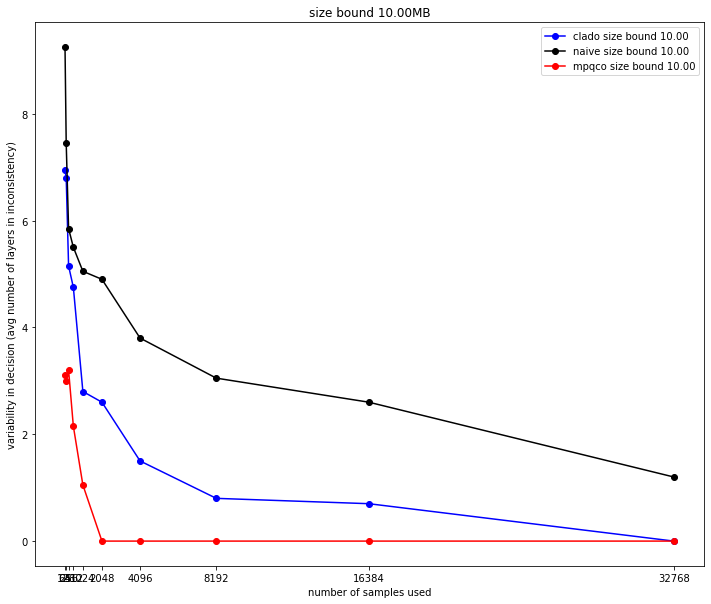

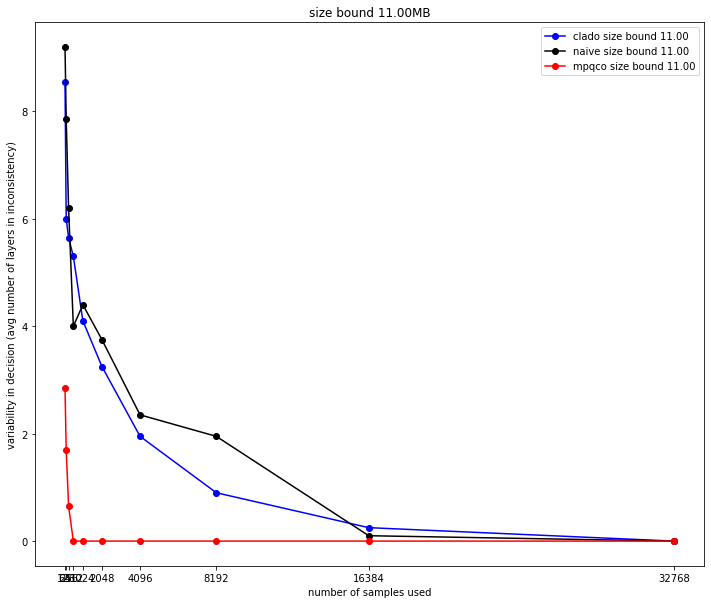

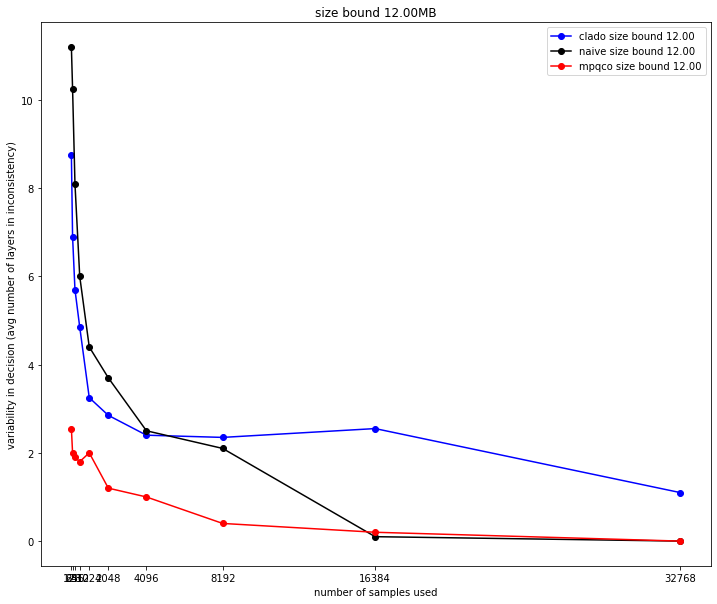

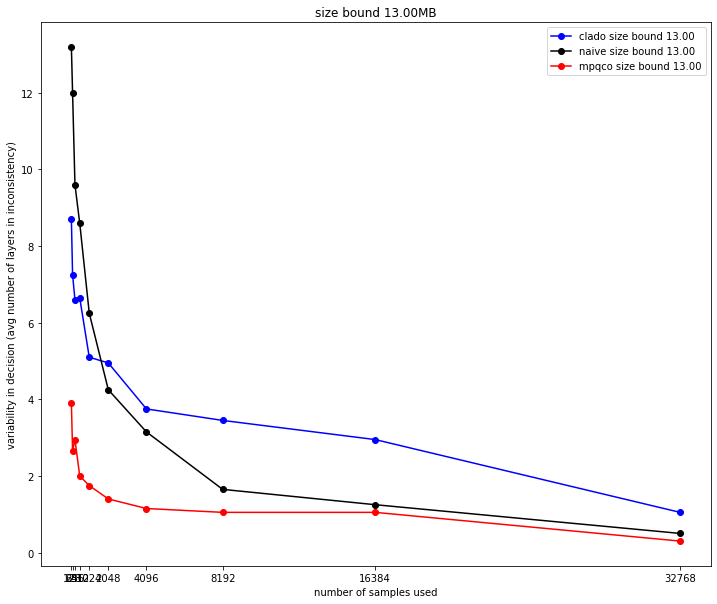

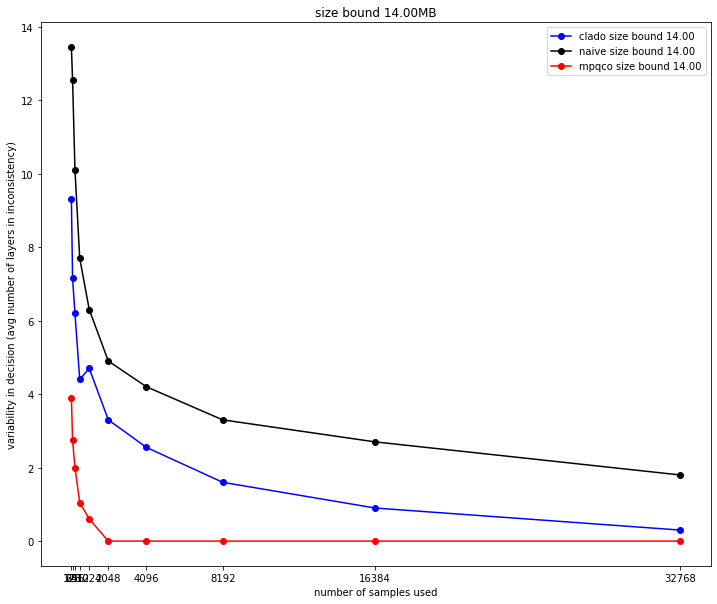

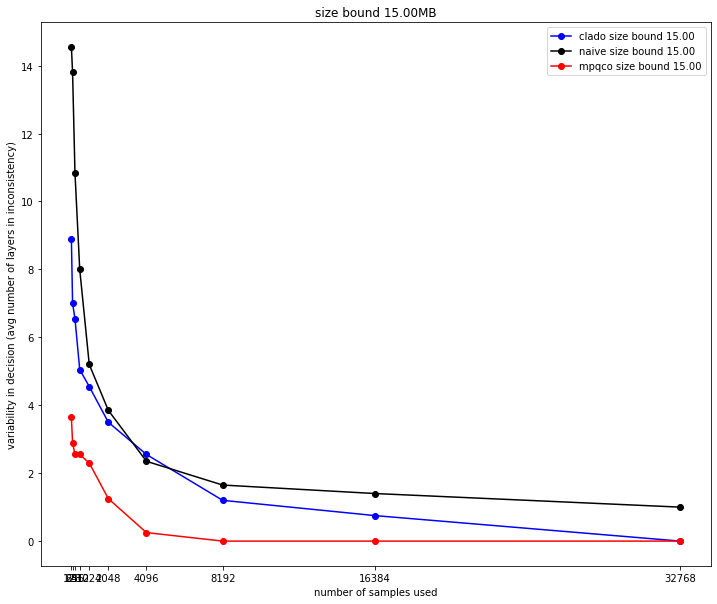

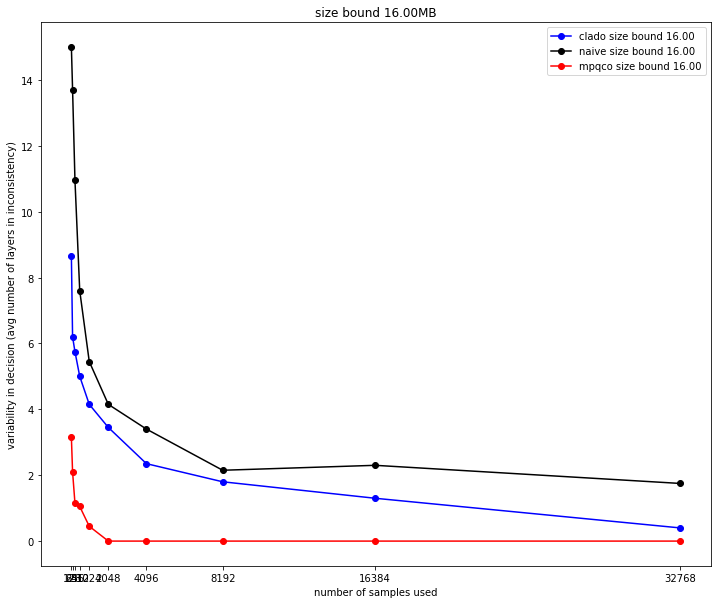

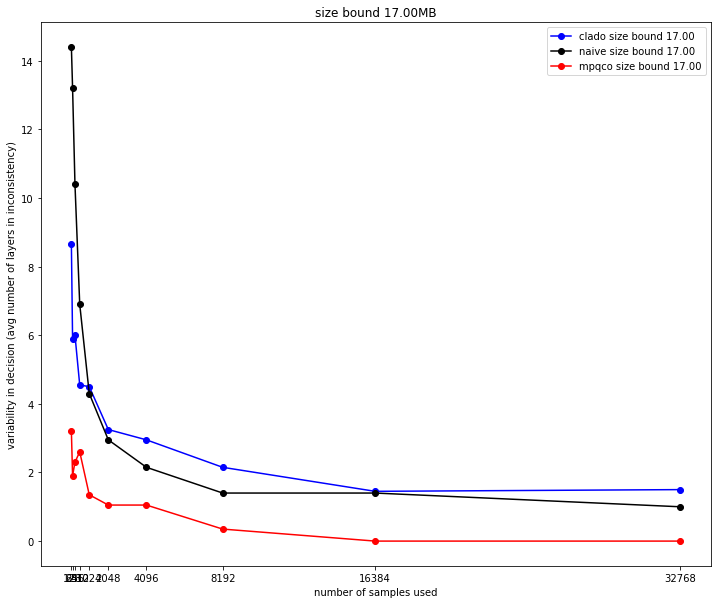

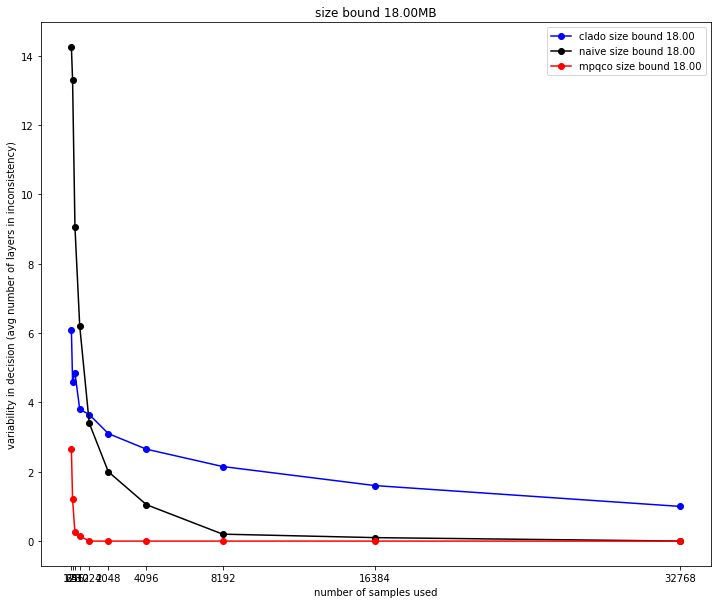

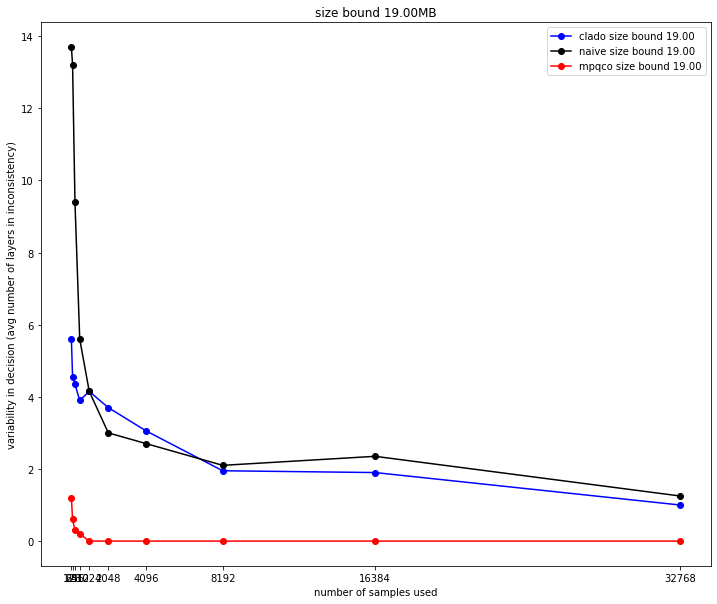

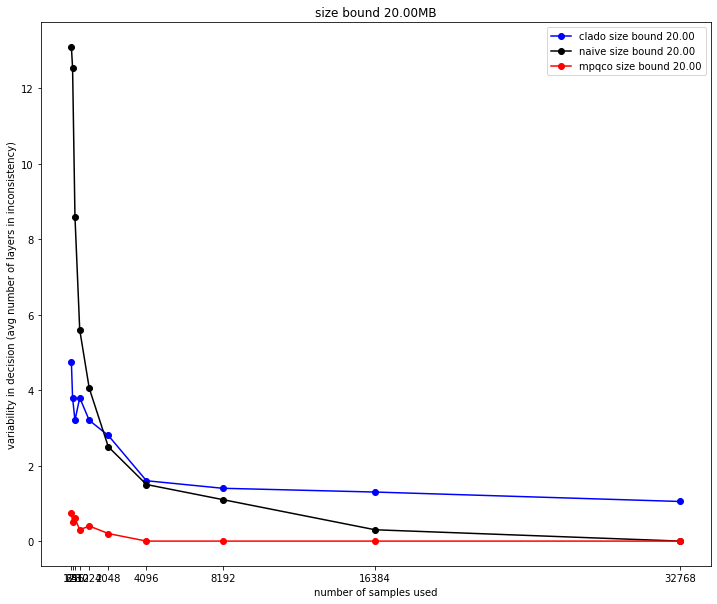

In [12]:
size_bounds = np.linspace(10,20,11)
for constraint_index in range(11):
    var_clados,var_naives,var_mpqcos = [],[],[]
    n_batch_id=0
    for n_batch in sset_batches:
        var_clado = avg_diff(clado_decisions_[:,n_batch_id,constraint_index,:])
        var_naive = avg_diff(naive_decisions_[:,n_batch_id,constraint_index,:])
        var_mpqco = avg_diff(mpqco_decisions_[:,n_batch_id,constraint_index,:])
        var_clados.append(var_clado/2)
        var_naives.append(var_naive/2)
        var_mpqcos.append(var_mpqco/2)
        n_batch_id += 1
    
    plt.plot(sset_batches*64,var_clados,color='blue',marker='o',
             label=f'clado size bound {size_bounds[constraint_index]:.2f}')
    plt.plot(sset_batches*64,var_naives,color='black',marker='o',
             label=f'naive size bound {size_bounds[constraint_index]:.2f}')
    plt.plot(sset_batches*64,var_mpqcos,color='red',marker='o',
             label=f'mpqco size bound {size_bounds[constraint_index]:.2f}') 
    plt.legend()
    plt.ylabel('variability in decision (avg number of layers in inconsistency)')
    plt.xlabel('number of samples used')
    plt.title(f'size bound {size_bounds[constraint_index]:.2f}MB')
    plt.xticks(sset_batches*64)
    plt.show()

## Binary search on sample size

In [ ]:
np.random.seed(0)
shuffle = np.random.choice(tail-head+1,tail-head+1,replace=False)
n_batch = 1


while 2*n_batch <= shuffle.shape[0]:
    
    
    clado_ltilde1 = batch_Ltildes_clado[shuffle[:n_batch]].mean(axis=0)
    mpqco_ltilde1 = batch_Ltildes_mpqco[shuffle[:n_batch]].mean(axis=0)
    clado_ltilde2 = batch_Ltildes_clado[shuffle[n_batch:2*n_batch]].mean(axis=0)
    mpqco_ltilde2 = batch_Ltildes_mpqco[shuffle[n_batch:2*n_batch]].mean(axis=0)


    constraint_index = 0
    diff_clado,diff_naive,diff_mpqco = [],[],[]
    for size_bound in np.linspace(10,20,11):
        # CLADO Way
        cached_grad = Ltilde2CachedGrad(clado_ltilde1)
        v_clado1 = MIQCP_optimize(cached_grad=cached_grad,
                           layer_bitops=layer_bitops,
                           layer_size=layer_size,
                           schemes_per_layer=len(aw_scheme),
                           bitops_bound=np.inf,size_bound=size_bound,
                           naive=False,PSD=True)
        cached_grad = Ltilde2CachedGrad(clado_ltilde2)
        v_clado2 = MIQCP_optimize(cached_grad=cached_grad,
                           layer_bitops=layer_bitops,
                           layer_size=layer_size,
                           schemes_per_layer=len(aw_scheme),
                           bitops_bound=np.inf,size_bound=size_bound,
                           naive=False,PSD=True)
        diff_clado.append(np.abs(v_clado1.value-v_clado2.value).sum()/2)


        # naive Way
        cached_grad = Ltilde2CachedGrad(clado_ltilde1)
        v_naive1 = MIQCP_optimize(cached_grad=cached_grad,
                           layer_bitops=layer_bitops,
                           layer_size=layer_size,
                           schemes_per_layer=len(aw_scheme),
                           bitops_bound=np.inf,size_bound=size_bound,
                           naive=True,PSD=False)
        cached_grad = Ltilde2CachedGrad(clado_ltilde2)
        v_naive2 = MIQCP_optimize(cached_grad=cached_grad,
                           layer_bitops=layer_bitops,
                           layer_size=layer_size,
                           schemes_per_layer=len(aw_scheme),
                           bitops_bound=np.inf,size_bound=size_bound,
                           naive=True,PSD=False)
        diff_naive.append(np.abs(v_naive1.value-v_naive2.value).sum()/2)

        # MPQCO Way
        v_mpqco1 = MIQCP_optimize(cached_grad=mpqco_ltilde1,
                           layer_bitops=layer_bitops,
                           layer_size=layer_size,
                           schemes_per_layer=len(aw_scheme),
                           bitops_bound=np.inf,size_bound=size_bound,
                           naive=True,PSD=False)
        
        v_mpqco2 = MIQCP_optimize(cached_grad=mpqco_ltilde2,
                           layer_bitops=layer_bitops,
                           layer_size=layer_size,
                           schemes_per_layer=len(aw_scheme),
                           bitops_bound=np.inf,size_bound=size_bound,
                           naive=True,PSD=False)
        diff_mpqco.append(np.abs(v_mpqco1.value-v_mpqco2.value).sum()/2)

        constraint_index += 1
    print(f'{n_batch*64} samples')
    print('clado diff',[f'{(diff_clado[i]):.1f}' for i in range(len(diff_clado))])
    print('naive diff',[f'{(diff_naive[i]):.1f}' for i in range(len(diff_naive))])
    print('mpqco diff',[f'{(diff_mpqco[i]):.1f}' for i in range(len(diff_mpqco))])
    n_batch *= 2
        

In [ ]:
np.random.seed(1)
shuffle = np.random.choice(tail-head+1,tail-head+1,replace=False)
n_batch = 1


while 2*n_batch <= shuffle.shape[0]:
    
    
    clado_ltilde1 = batch_Ltildes_clado[shuffle[:n_batch]].mean(axis=0)
    mpqco_ltilde1 = batch_Ltildes_mpqco[shuffle[:n_batch]].mean(axis=0)
    clado_ltilde2 = batch_Ltildes_clado[shuffle[n_batch:2*n_batch]].mean(axis=0)
    mpqco_ltilde2 = batch_Ltildes_mpqco[shuffle[n_batch:2*n_batch]].mean(axis=0)


    constraint_index = 0
    diff_clado,diff_naive,diff_mpqco = [],[],[]
    for size_bound in np.linspace(10,20,11):
        # CLADO Way
        cached_grad = Ltilde2CachedGrad(clado_ltilde1)
        v_clado1 = MIQCP_optimize(cached_grad=cached_grad,
                           layer_bitops=layer_bitops,
                           layer_size=layer_size,
                           schemes_per_layer=len(aw_scheme),
                           bitops_bound=np.inf,size_bound=size_bound,
                           naive=False,PSD=True)
        cached_grad = Ltilde2CachedGrad(clado_ltilde2)
        v_clado2 = MIQCP_optimize(cached_grad=cached_grad,
                           layer_bitops=layer_bitops,
                           layer_size=layer_size,
                           schemes_per_layer=len(aw_scheme),
                           bitops_bound=np.inf,size_bound=size_bound,
                           naive=False,PSD=True)
        diff_clado.append(np.abs(v_clado1.value-v_clado2.value).sum()/2)


        # naive Way
        cached_grad = Ltilde2CachedGrad(clado_ltilde1)
        v_naive1 = MIQCP_optimize(cached_grad=cached_grad,
                           layer_bitops=layer_bitops,
                           layer_size=layer_size,
                           schemes_per_layer=len(aw_scheme),
                           bitops_bound=np.inf,size_bound=size_bound,
                           naive=True,PSD=False)
        cached_grad = Ltilde2CachedGrad(clado_ltilde2)
        v_naive2 = MIQCP_optimize(cached_grad=cached_grad,
                           layer_bitops=layer_bitops,
                           layer_size=layer_size,
                           schemes_per_layer=len(aw_scheme),
                           bitops_bound=np.inf,size_bound=size_bound,
                           naive=True,PSD=False)
        diff_naive.append(np.abs(v_naive1.value-v_naive2.value).sum()/2)

        # MPQCO Way
        v_mpqco1 = MIQCP_optimize(cached_grad=mpqco_ltilde1,
                           layer_bitops=layer_bitops,
                           layer_size=layer_size,
                           schemes_per_layer=len(aw_scheme),
                           bitops_bound=np.inf,size_bound=size_bound,
                           naive=True,PSD=False)
        
        v_mpqco2 = MIQCP_optimize(cached_grad=mpqco_ltilde2,
                           layer_bitops=layer_bitops,
                           layer_size=layer_size,
                           schemes_per_layer=len(aw_scheme),
                           bitops_bound=np.inf,size_bound=size_bound,
                           naive=True,PSD=False)
        diff_mpqco.append(np.abs(v_mpqco1.value-v_mpqco2.value).sum()/2)

        constraint_index += 1
    print(f'{n_batch*64} samples')
    print('clado diff',[f'{diff_clado[i]:.1f}' for i in range(len(diff_clado))])
    print('naive diff',[f'{diff_naive[i]:.1f}' for i in range(len(diff_naive))])
    print('mpqco diff',[f'{diff_mpqco[i]:.1f}' for i in range(len(diff_mpqco))])
    n_batch *= 2
        

In [23]:
diff_cladoss,diff_naivess,diff_mpqcoss = [],[],[]

perf1_cladoss,perf1_naivess,perf1_mpqcoss = [],[],[]
perf2_cladoss,perf2_naivess,perf2_mpqcoss = [],[],[]

size1_cladoss,size1_naivess,size1_mpqcoss = [],[],[]
size2_cladoss,size2_naivess,size2_mpqcoss = [],[],[]

for seed in range(12):
    print(f'seed {seed}')
    np.random.seed(seed)
    shuffle = np.random.choice(tail-head+1,tail-head+1,replace=False)
    n_batch = 1
    
    diff_clados,diff_naives,diff_mpqcos = [],[],[]
    perf1_clados,perf1_naives,perf1_mpqcos = [],[],[]
    perf2_clados,perf2_naives,perf2_mpqcos = [],[],[]

    size1_clados,size1_naives,size1_mpqcos = [],[],[]
    size2_clados,size2_naives,size2_mpqcos = [],[],[]

    while 2*n_batch <= shuffle.shape[0]:


        clado_ltilde1 = batch_Ltildes_clado[shuffle[:n_batch]].mean(axis=0)
        mpqco_ltilde1 = batch_Ltildes_mpqco[shuffle[:n_batch]].mean(axis=0)
        clado_ltilde2 = batch_Ltildes_clado[shuffle[n_batch:2*n_batch]].mean(axis=0)
        mpqco_ltilde2 = batch_Ltildes_mpqco[shuffle[n_batch:2*n_batch]].mean(axis=0)


        constraint_index = 0
        diff_clado,diff_naive,diff_mpqco = [],[],[]
        perf1_clado,perf1_naive,perf1_mpqco = [],[],[]
        perf2_clado,perf2_naive,perf2_mpqco = [],[],[]

        size1_clado,size1_naive,size1_mpqco = [],[],[]
        size2_clado,size2_naive,size2_mpqco = [],[],[]
        
        for size_bound in np.linspace(10,20,11):
            # CLADO Way
            cached_grad = Ltilde2CachedGrad(clado_ltilde1)
            v_clado1 = MIQCP_optimize(cached_grad=cached_grad,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=False,PSD=True)
            cached_grad = Ltilde2CachedGrad(clado_ltilde2)
            v_clado2 = MIQCP_optimize(cached_grad=cached_grad,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=False,PSD=True)
            diff_clado.append(np.abs(v_clado1.value-v_clado2.value).sum()/2)
            
            perf1,size1,bitops1 = evaluate_decision(v_clado1.value)
            perf2,size2,bitops2 = evaluate_decision(v_clado2.value)
            
            perf1_clado.append(perf1)
            size1_clado.append(size1)
            perf2_clado.append(perf2)
            size2_clado.append(size2)


            # naive Way
            cached_grad = Ltilde2CachedGrad(clado_ltilde1)
            v_naive1 = MIQCP_optimize(cached_grad=cached_grad,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=True,PSD=False)
            cached_grad = Ltilde2CachedGrad(clado_ltilde2)
            v_naive2 = MIQCP_optimize(cached_grad=cached_grad,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=True,PSD=False)
            diff_naive.append(np.abs(v_naive1.value-v_naive2.value).sum()/2)
            
            perf1,size1,bitops1 = evaluate_decision(v_naive1.value)
            perf2,size2,bitops2 = evaluate_decision(v_naive2.value)
            
            perf1_naive.append(perf1)
            size1_naive.append(size1)
            perf2_naive.append(perf2)
            size2_naive.append(size2)

            # MPQCO Way
            v_mpqco1 = MIQCP_optimize(cached_grad=mpqco_ltilde1,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=True,PSD=False)

            v_mpqco2 = MIQCP_optimize(cached_grad=mpqco_ltilde2,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=True,PSD=False)
            diff_mpqco.append(np.abs(v_mpqco1.value-v_mpqco2.value).sum()/2)
            
            perf1,size1,bitops1 = evaluate_decision(v_mpqco1.value)
            perf2,size2,bitops2 = evaluate_decision(v_mpqco2.value)
            
            perf1_mpqco.append(perf1)
            size1_mpqco.append(size1)
            perf2_mpqco.append(perf2)
            size2_mpqco.append(size2)

            constraint_index += 1
            
        print(f'{n_batch*64} samples')
        print('clado diff',[f'{diff_clado[i]:.1f}' for i in range(len(diff_clado))])
        print('naive diff',[f'{diff_naive[i]:.1f}' for i in range(len(diff_naive))])
        print('mpqco diff',[f'{diff_mpqco[i]:.1f}' for i in range(len(diff_mpqco))])
        diff_clados.append(diff_clado)
        diff_naives.append(diff_naive)
        diff_mpqcos.append(diff_mpqco)
        
        perf1_clados.append(perf1_clado)
        perf1_naives.append(perf1_naive)
        perf1_mpqcos.append(perf1_mpqco)
        
        perf2_clados.append(perf2_clado)
        perf2_naives.append(perf2_naive)
        perf2_mpqcos.append(perf2_mpqco)
        
        size1_clados.append(size1_clado)
        size1_naives.append(size1_naive)
        size1_mpqcos.append(size1_mpqco)
        
        size2_clados.append(size2_clado)
        size2_naives.append(size2_naive)
        size2_mpqcos.append(size2_mpqco)
        
        n_batch *= 2
    diff_cladoss.append(diff_clados)
    diff_naivess.append(diff_naives)
    diff_mpqcoss.append(diff_mpqcos)
    
    perf1_cladoss.append(perf1_clados)
    perf1_naivess.append(perf1_naives)
    perf1_mpqcoss.append(perf1_mpqcos)

    perf2_cladoss.append(perf2_clados)
    perf2_naivess.append(perf2_naives)
    perf2_mpqcoss.append(perf2_mpqcos)

    size1_cladoss.append(size1_clados)
    size1_naivess.append(size1_naives)
    size1_mpqcoss.append(size1_mpqcos)

    size2_cladoss.append(size2_clados)
    size2_naivess.append(size2_naives)
    size2_mpqcoss.append(size2_mpqcos)
        

seed 0
64 samples
clado diff ['10.0', '15.0', '11.0', '12.0', '16.0', '15.0', '16.0', '5.0', '4.0', '0.0', '4.0']
naive diff ['16.0', '10.0', '12.0', '13.0', '16.0', '19.0', '23.0', '23.0', '21.0', '20.0', '21.0']
mpqco diff ['4.0', '7.0', '6.0', '8.0', '6.0', '5.0', '6.0', '7.0', '5.0', '2.0', '2.0']
128 samples
clado diff ['11.0', '10.0', '12.0', '11.0', '14.0', '12.0', '10.0', '11.0', '5.0', '5.0', '9.0']
naive diff ['9.0', '16.0', '19.0', '17.0', '19.0', '23.0', '23.0', '18.0', '21.0', '24.0', '21.0']
mpqco diff ['5.0', '0.0', '4.0', '6.0', '5.0', '5.0', '5.0', '3.0', '3.0', '2.0', '0.0']
256 samples
clado diff ['11.0', '9.0', '10.0', '8.0', '0.0', '8.0', '7.0', '7.0', '5.0', '3.0', '4.0']
naive diff ['7.0', '7.0', '13.0', '13.0', '14.0', '16.0', '17.0', '17.0', '18.0', '14.0', '14.0']
mpqco diff ['3.0', '0.0', '2.0', '4.0', '6.0', '5.0', '5.0', '3.0', '3.0', '0.0', '0.0']
512 samples
clado diff ['6.0', '6.0', '7.0', '8.0', '6.0', '5.0', '7.0', '7.0', '5.0', '6.0', '10.0']
naive di

256 samples
clado diff ['12.0', '14.0', '10.0', '16.0', '14.0', '15.0', '15.0', '14.0', '13.0', '13.0', '10.0']
naive diff ['8.0', '4.0', '12.0', '15.0', '16.0', '17.0', '17.0', '16.0', '13.0', '14.0', '17.0']
mpqco diff ['7.0', '0.0', '2.0', '4.0', '0.0', '5.0', '0.0', '0.0', '0.0', '2.0', '0.0']
512 samples
clado diff ['11.0', '9.0', '9.0', '13.0', '9.0', '6.0', '14.0', '9.0', '6.0', '1.0', '3.0']
naive diff ['10.0', '9.0', '5.0', '11.0', '12.0', '10.0', '15.0', '9.0', '8.0', '9.0', '7.0']
mpqco diff ['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '2.0']
1024 samples
clado diff ['5.0', '5.0', '3.0', '11.0', '9.0', '7.0', '3.0', '2.0', '7.0', '2.0', '5.0']
naive diff ['6.0', '4.0', '4.0', '8.0', '6.0', '8.0', '6.0', '6.0', '5.0', '5.0', '7.0']
mpqco diff ['0.0', '0.0', '4.0', '2.0', '0.0', '5.0', '0.0', '0.0', '0.0', '0.0', '0.0']
2048 samples
clado diff ['3.0', '4.0', '5.0', '8.0', '8.0', '7.0', '5.0', '5.0', '3.0', '5.0', '5.0']
naive diff ['7.0', '11.0', '3.0

1024 samples
clado diff ['9.0', '4.0', '5.0', '5.0', '8.0', '5.0', '2.0', '4.0', '5.0', '4.0', '7.0']
naive diff ['4.0', '8.0', '10.0', '7.0', '9.0', '11.0', '10.0', '7.0', '6.0', '7.0', '8.0']
mpqco diff ['0.0', '0.0', '0.0', '0.0', '0.0', '5.0', '0.0', '7.0', '0.0', '0.0', '2.0']
2048 samples
clado diff ['0.0', '0.0', '0.0', '8.0', '0.0', '0.0', '2.0', '3.0', '2.0', '2.0', '2.0']
naive diff ['6.0', '6.0', '6.0', '9.0', '7.0', '5.0', '6.0', '3.0', '4.0', '4.0', '4.0']
mpqco diff ['0.0', '0.0', '2.0', '3.0', '0.0', '5.0', '0.0', '0.0', '0.0', '0.0', '0.0']
4096 samples
clado diff ['2.0', '5.0', '6.0', '3.0', '7.0', '0.0', '4.0', '3.0', '4.0', '4.0', '5.0']
naive diff ['5.0', '0.0', '0.0', '4.0', '6.0', '0.0', '3.0', '0.0', '2.0', '2.0', '0.0']
mpqco diff ['0.0', '0.0', '4.0', '3.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
8192 samples
clado diff ['4.0', '5.0', '2.0', '8.0', '0.0', '5.0', '3.0', '3.0', '5.0', '5.0', '3.0']
naive diff ['3.0', '0.0', '0.0', '2.0', '5.0', '3.0', '

4096 samples
clado diff ['2.0', '2.0', '2.0', '9.0', '0.0', '4.0', '0.0', '6.0', '2.0', '0.0', '1.0']
naive diff ['5.0', '3.0', '3.0', '4.0', '4.0', '5.0', '6.0', '3.0', '3.0', '5.0', '6.0']
mpqco diff ['0.0', '0.0', '0.0', '3.0', '0.0', '5.0', '0.0', '0.0', '0.0', '0.0', '0.0']
8192 samples
clado diff ['2.0', '5.0', '2.0', '3.0', '2.0', '5.0', '2.0', '4.0', '6.0', '4.0', '2.0']
naive diff ['10.0', '2.0', '2.0', '4.0', '6.0', '5.0', '6.0', '3.0', '2.0', '5.0', '4.0']
mpqco diff ['0.0', '0.0', '0.0', '3.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
16384 samples
clado diff ['4.0', '0.0', '6.0', '6.0', '0.0', '5.0', '3.0', '3.0', '5.0', '4.0', '2.0']
naive diff ['3.0', '0.0', '0.0', '0.0', '4.0', '3.0', '3.0', '3.0', '2.0', '5.0', '0.0']
mpqco diff ['0.0', '0.0', '0.0', '3.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
seed 10
64 samples
clado diff ['9.0', '15.0', '16.0', '18.0', '12.0', '17.0', '18.0', '23.0', '16.0', '15.0', '17.0']
naive diff ['14.0', '16.0', '19.0', '20.

In [24]:
diff_cladoss = np.array(diff_cladoss)
diff_naivess = np.array(diff_naivess)
diff_mpqcoss = np.array(diff_mpqcoss)

perf1_cladoss = np.array(perf1_cladoss)
perf1_naivess = np.array(perf1_naivess)
perf1_mpqcoss = np.array(perf1_mpqcoss)

perf2_cladoss = np.array(perf2_cladoss)
perf2_naivess = np.array(perf2_naivess)
perf2_mpqcoss = np.array(perf2_mpqcoss)

size1_cladoss = np.array(size1_cladoss)
size1_naivess = np.array(size1_naivess)
size1_mpqcoss = np.array(size1_mpqcoss)

size2_cladoss = np.array(size2_cladoss)
size2_naivess = np.array(size2_naivess)
size2_mpqcoss = np.array(size2_mpqcoss)



In [25]:
diff_cladoss.shape
perf1_cladoss.shape

(12, 9, 11)

In [35]:
acc1_cladoss = np.zeros(perf1_cladoss.shape)
acc2_cladoss = np.zeros(perf2_cladoss.shape)

acc1_naivess = np.zeros(perf1_cladoss.shape)
acc2_naivess = np.zeros(perf2_cladoss.shape)

acc1_mpqcoss = np.zeros(perf1_cladoss.shape)
acc2_mpqcoss = np.zeros(perf2_cladoss.shape)

for seed in range(perf1_cladoss.shape[0]):
    for size in range(perf1_cladoss.shape[1]):
        for cons in range(perf1_cladoss.shape[2]):
            acc1_cladoss[seed,size,cons] = perf1_cladoss[seed,size,cons]['top1']
            acc2_cladoss[seed,size,cons] = perf2_cladoss[seed,size,cons]['top1']
            acc1_naivess[seed,size,cons] = perf1_naivess[seed,size,cons]['top1']
            acc2_naivess[seed,size,cons] = perf2_naivess[seed,size,cons]['top1']
            acc1_mpqcoss[seed,size,cons] = perf1_mpqcoss[seed,size,cons]['top1']
            acc2_mpqcoss[seed,size,cons] = perf2_mpqcoss[seed,size,cons]['top1']
            

acc_cladoss = np.concatenate([acc1_cladoss,acc2_cladoss],axis=0)
acc_mpqcoss = np.concatenate([acc1_mpqcoss,acc2_mpqcoss],axis=0)
acc_naivess = np.concatenate([acc1_naivess,acc2_naivess],axis=0)

In [51]:
np.quantile(np.random.randn(10,10),0.5,axis=0)

array([ 0.16948822,  0.37109873, -0.26716495,  0.53776093, -0.30297603,
        0.11671591, -0.15790851,  0.57773667,  0.03772239,  0.32387213])

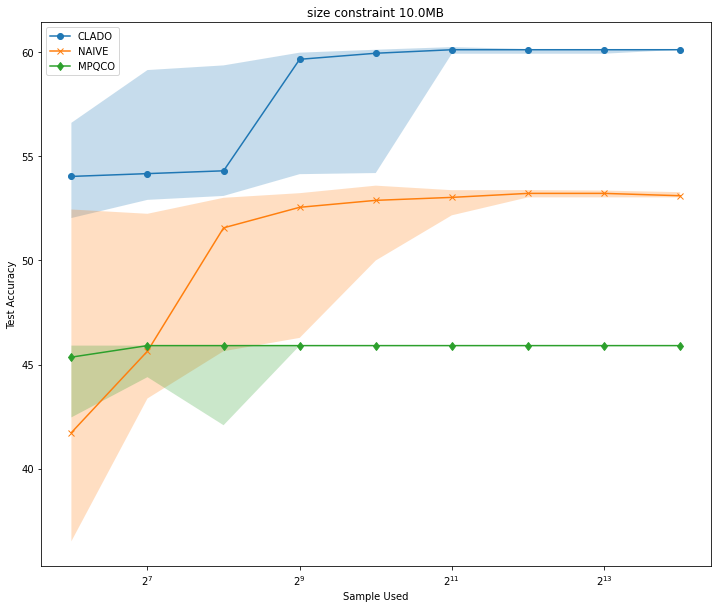

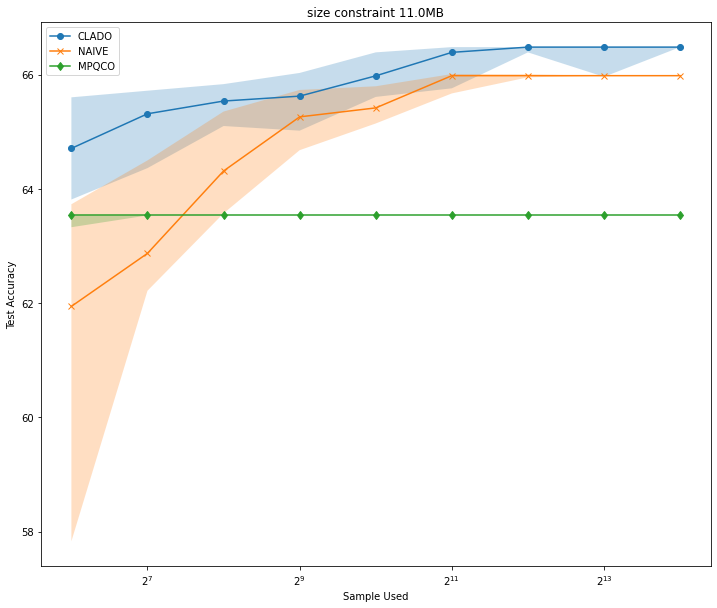

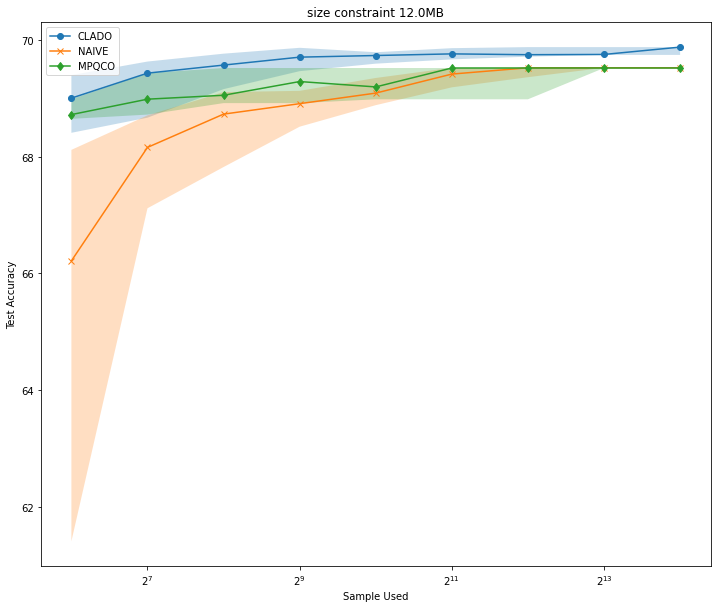

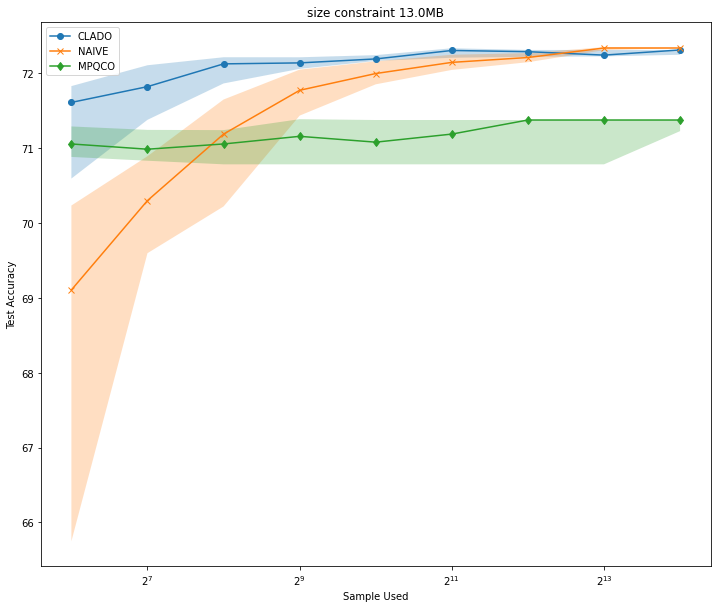

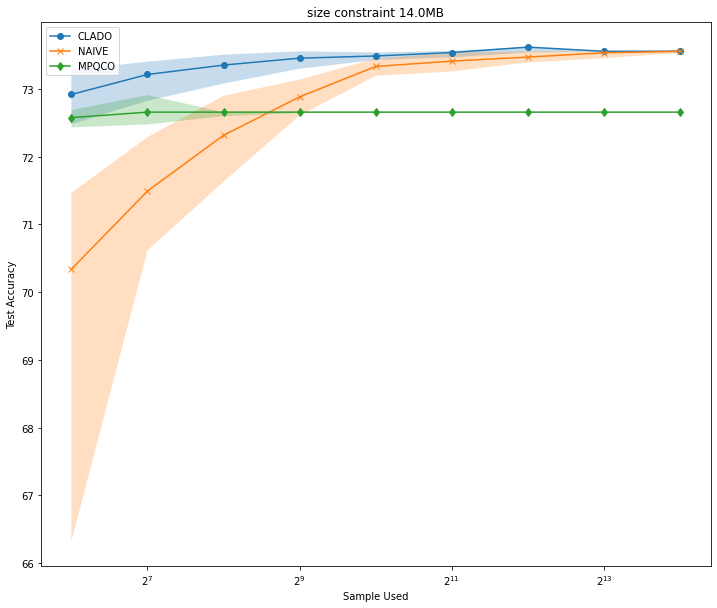

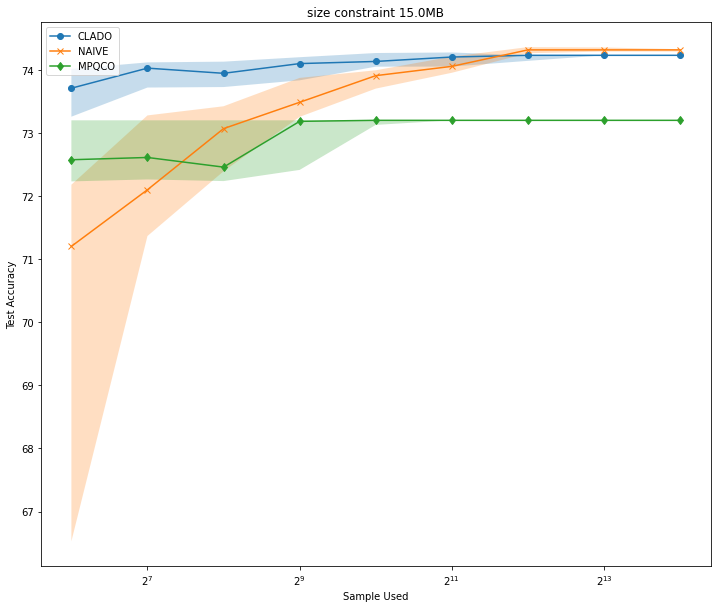

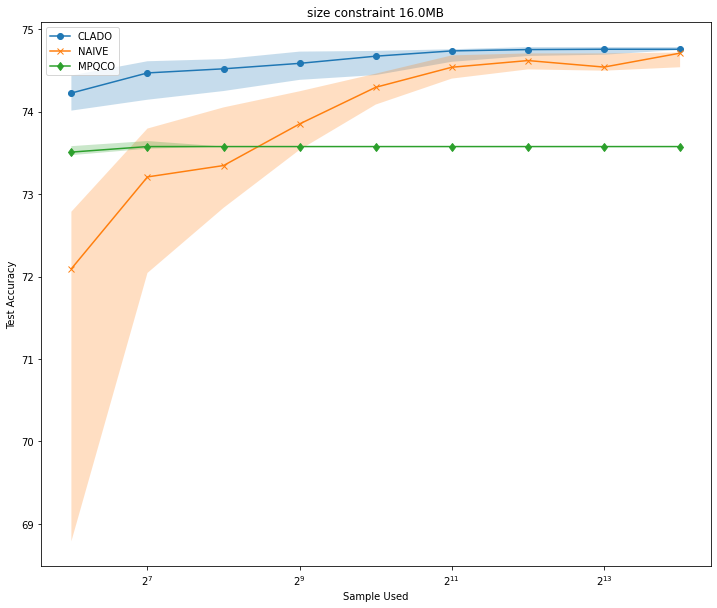

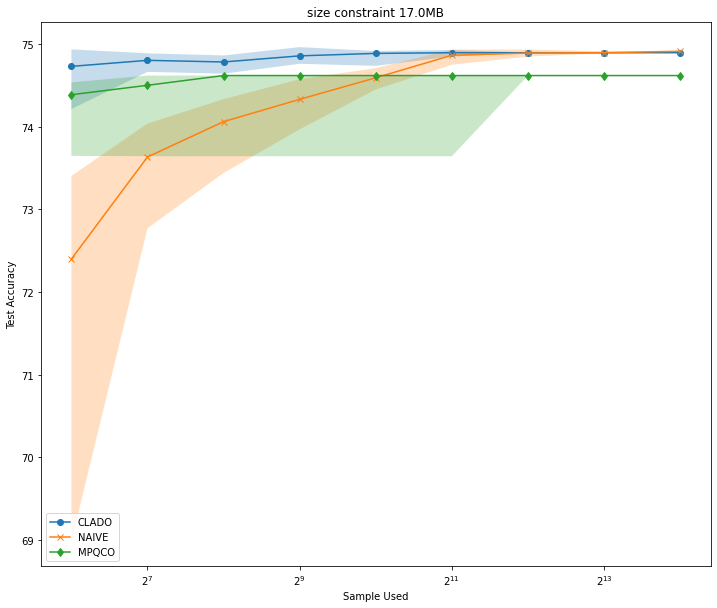

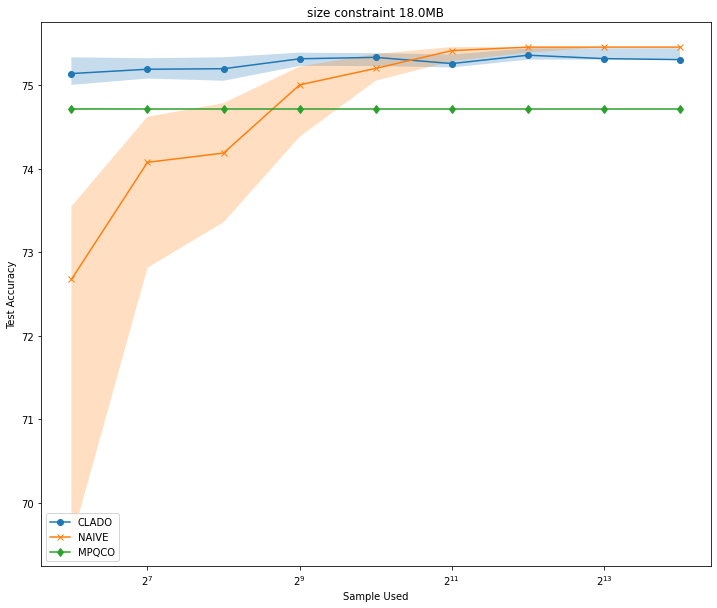

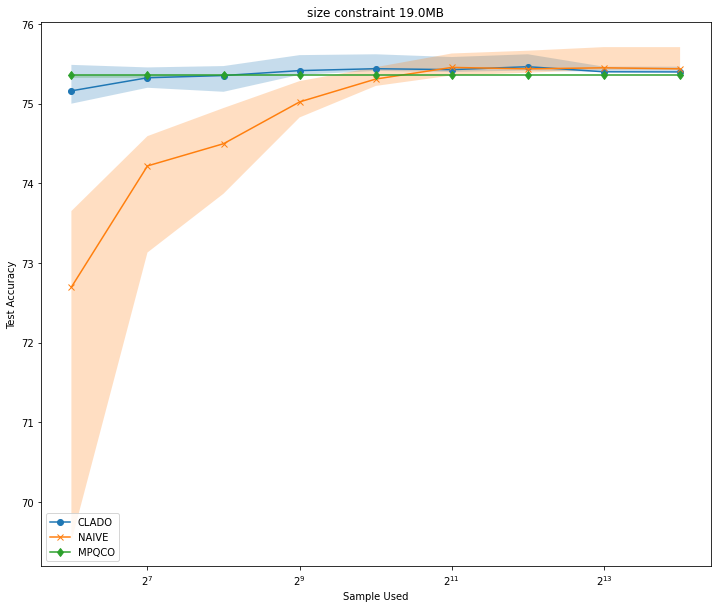

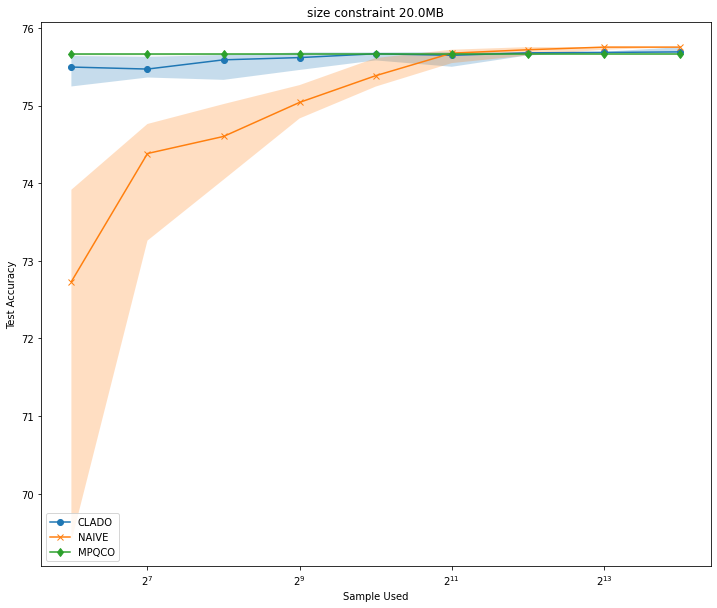

In [50]:
xs = 2**np.arange(acc_cladoss.shape[1]) * 64
for i in range(acc_cladoss.shape[2]):
    #plt.plot(xs,acc_cladoss[:,:,i].mean(axis=0),marker='o',label=f'CLADO Mean')
    plt.plot(xs,np.quantile(acc_cladoss[:,:,i],0.5,axis=0),marker='o',label=f'CLADO')
    plt.fill_between(xs,np.quantile(acc_cladoss[:,:,i],0.75,axis=0),
                     np.quantile(acc_cladoss[:,:,i],0.25,axis=0),alpha=0.25)
    
    #plt.plot(xs,acc_naivess[:,:,i].mean(axis=0),marker='x',label=f'NAIVE Mean')
    plt.plot(xs,np.quantile(acc_naivess[:,:,i],0.5,axis=0),marker='x',label=f'NAIVE')
    plt.fill_between(xs,np.quantile(acc_naivess[:,:,i],0.75,axis=0),
                     np.quantile(acc_naivess[:,:,i],0.25,axis=0),alpha=0.25)
    
    #plt.plot(xs,acc_mpqcoss[:,:,i].mean(axis=0),marker='d',label=f'MPQCO Mean')
    plt.plot(xs,np.quantile(acc_mpqcoss[:,:,i],0.5,axis=0),marker='d',label=f'MPQCO')
    plt.fill_between(xs,np.quantile(acc_mpqcoss[:,:,i],0.75,axis=0),
                     np.quantile(acc_mpqcoss[:,:,i],0.25,axis=0),alpha=0.25)
    
    plt.legend()
    plt.ylabel('Test Accuracy')
    plt.xlabel('Sample Used')
    plt.title(f'size constraint {np.linspace(10,20,11)[i]:.1f}MB')
    plt.xscale('log',base=2)
    plt.show()

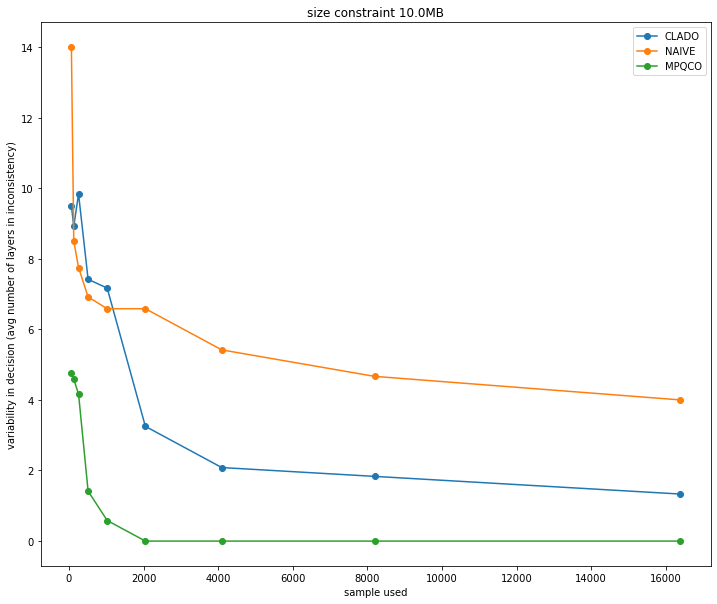

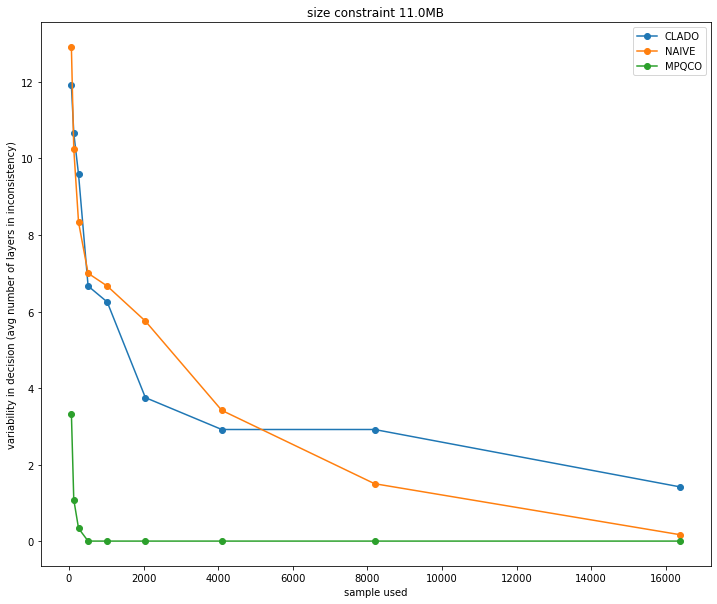

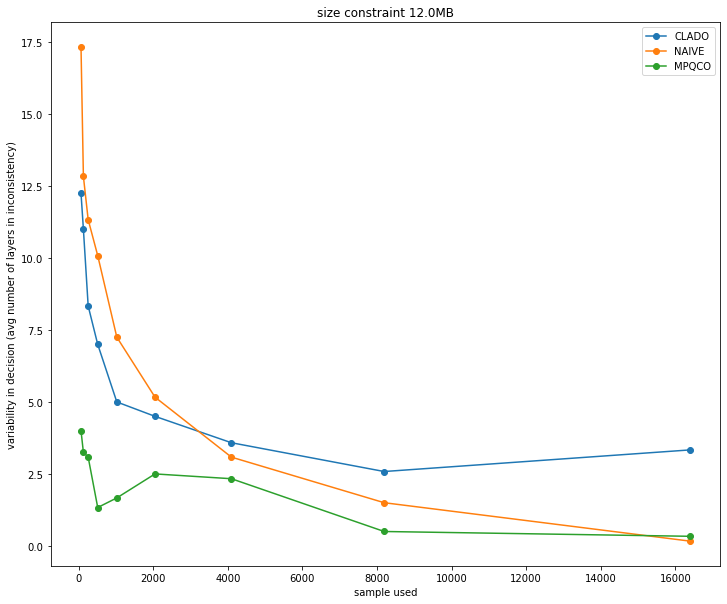

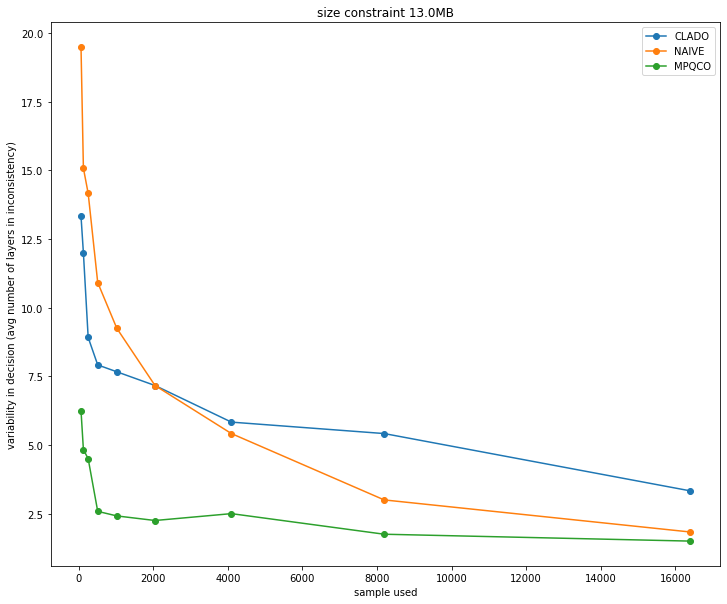

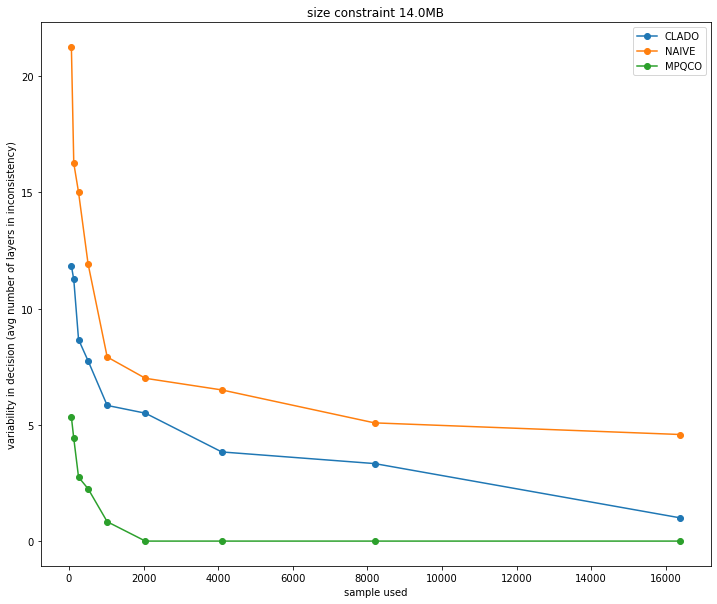

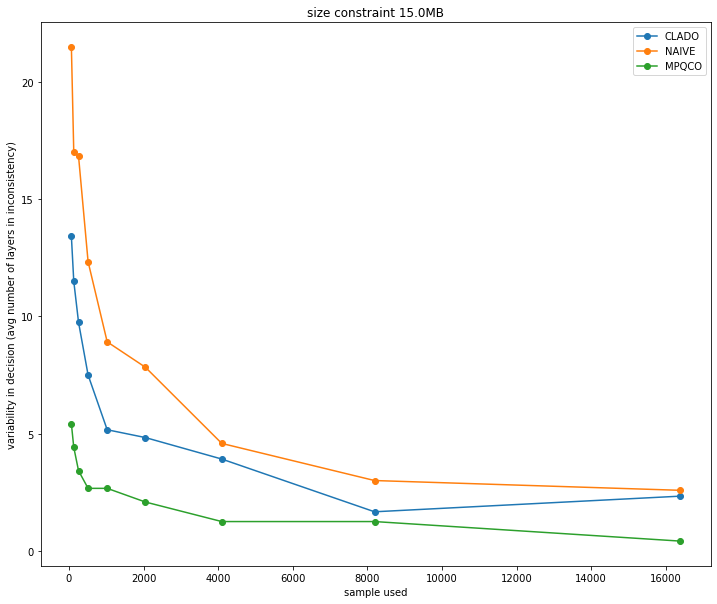

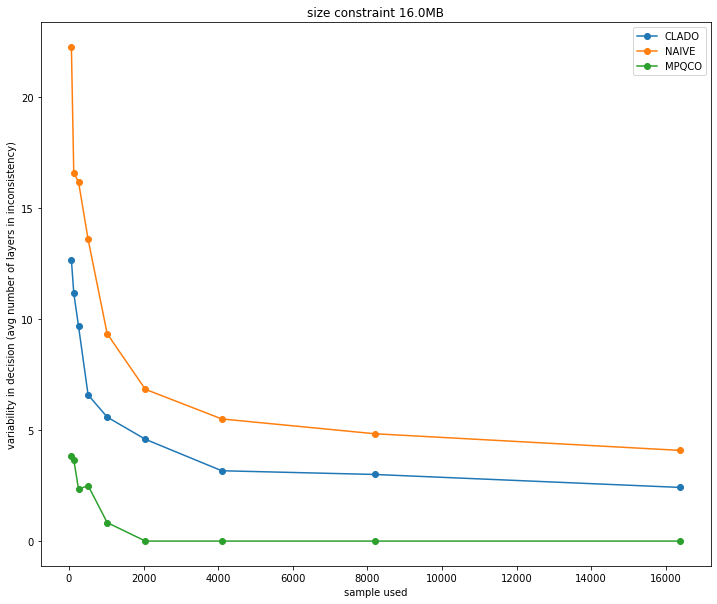

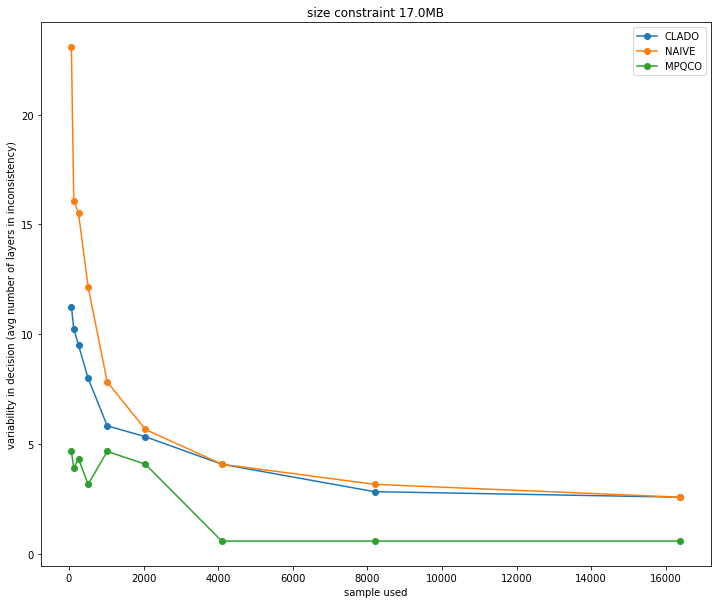

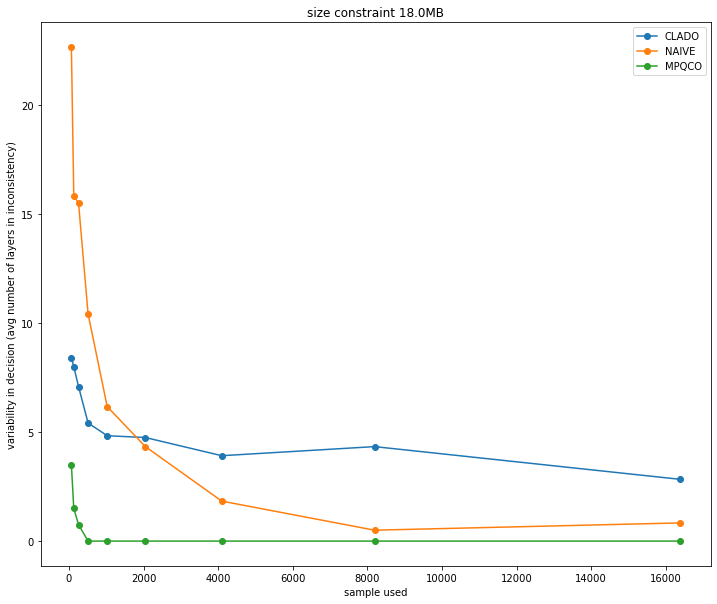

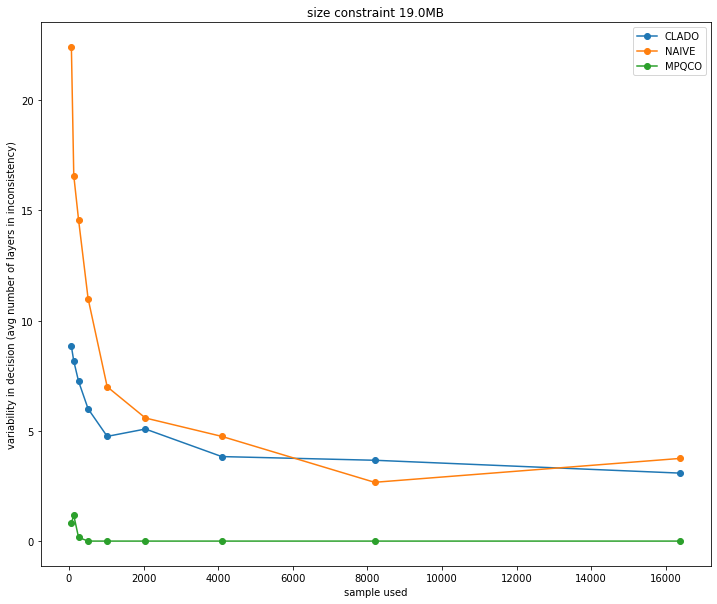

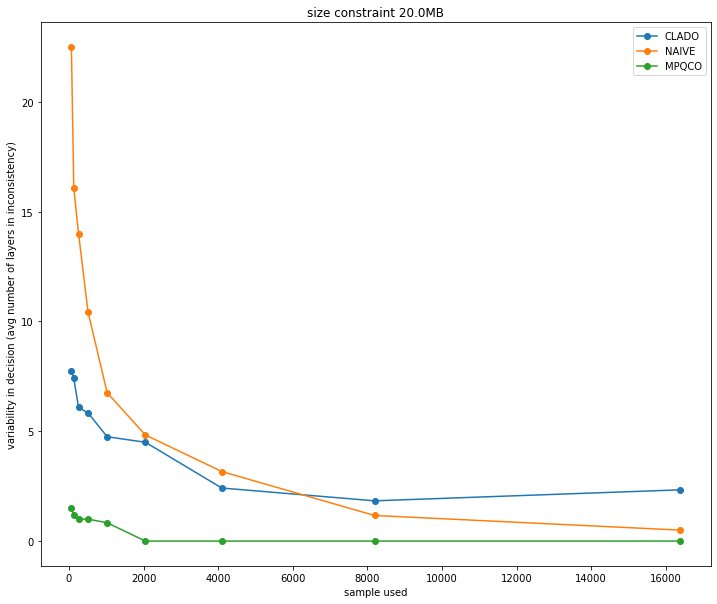

In [21]:
xs = 2**np.arange(diff_cladoss.shape[1]) * 64
for i in range(diff_cladoss.shape[2]):
    plt.plot(xs,diff_cladoss[:,:,i].mean(axis=0),marker='o',label=f'CLADO')
    plt.plot(xs,diff_naivess[:,:,i].mean(axis=0),marker='o',label=f'NAIVE')
    plt.plot(xs,diff_mpqcoss[:,:,i].mean(axis=0),marker='o',label=f'MPQCO')
    plt.legend()
    plt.ylabel('variability in decision (avg number of layers in inconsistency)')
    plt.xlabel('sample used')
    plt.title(f'size constraint {np.linspace(10,20,11)[i]:.1f}MB')
    plt.show()

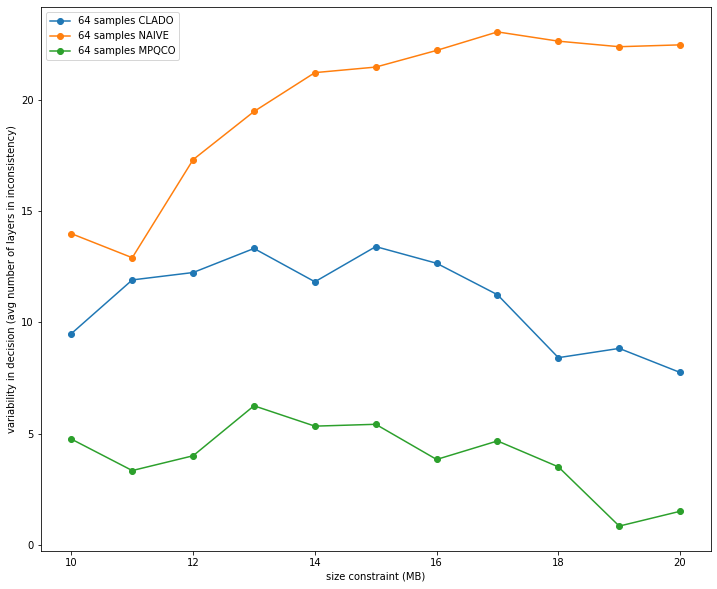

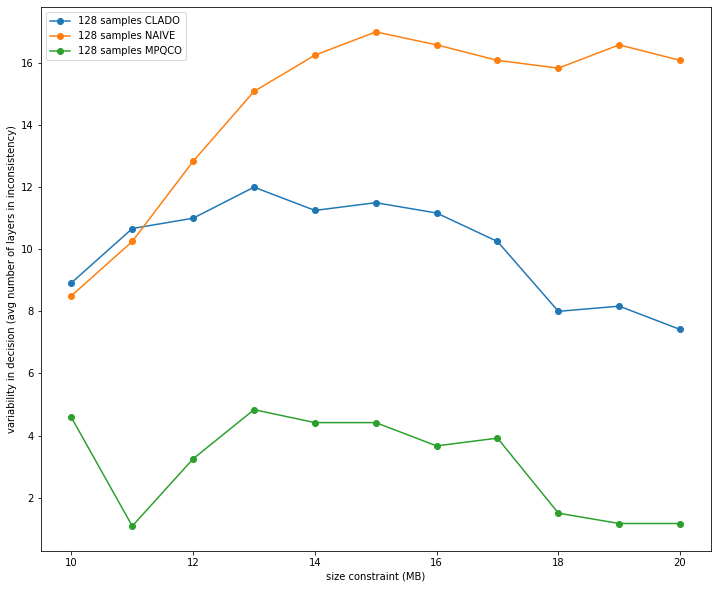

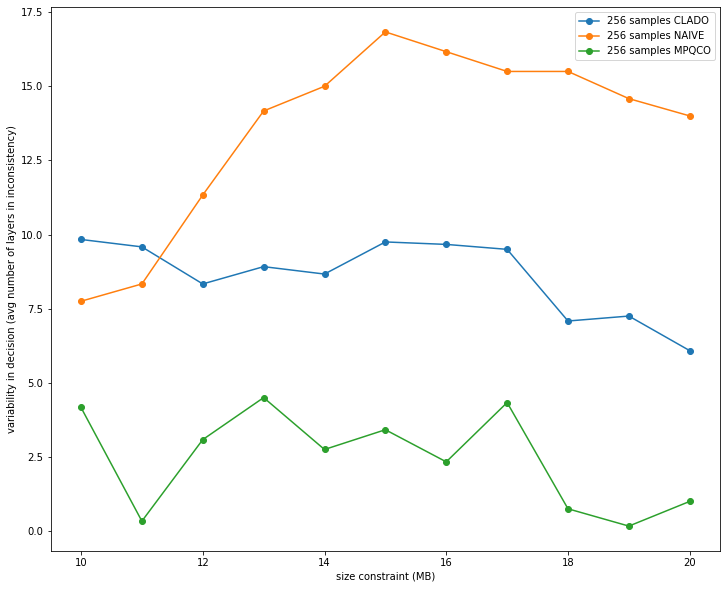

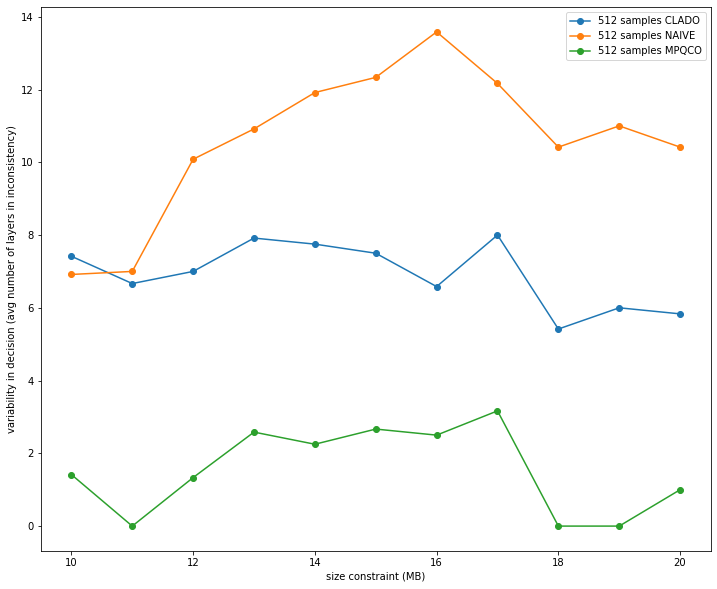

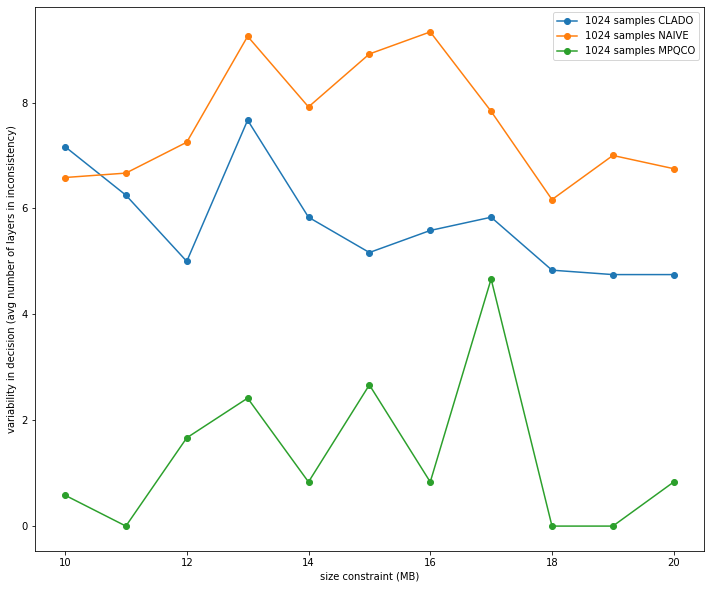

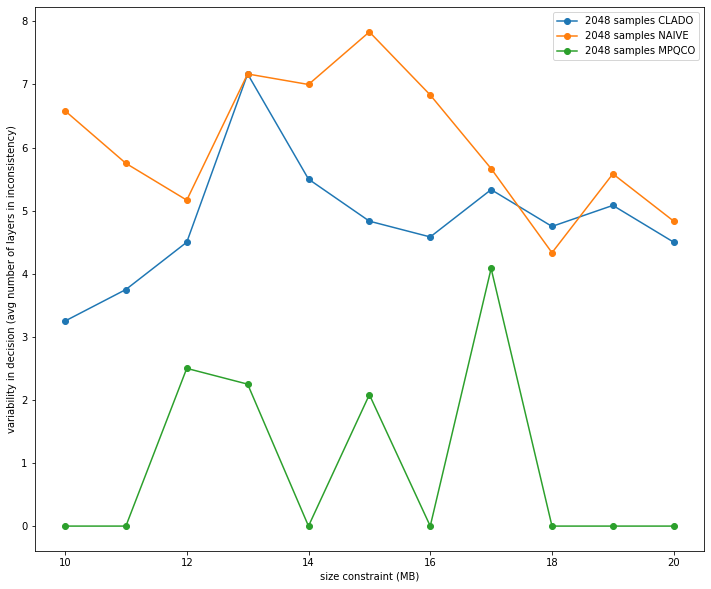

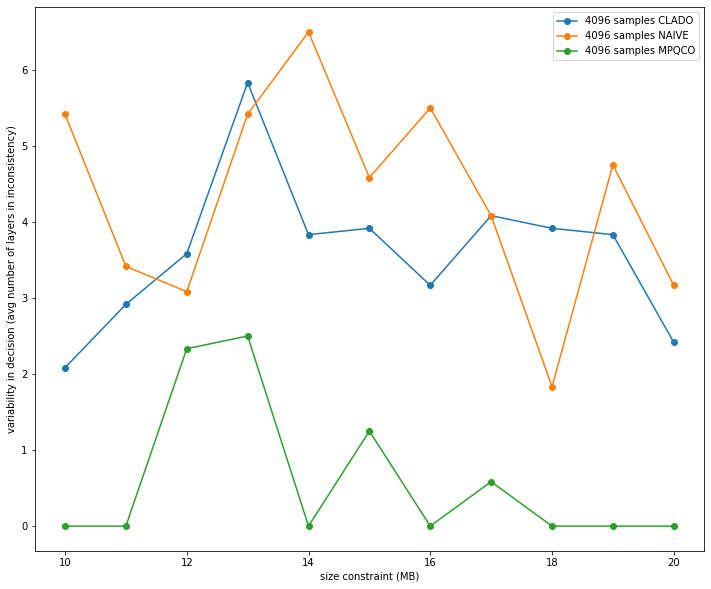

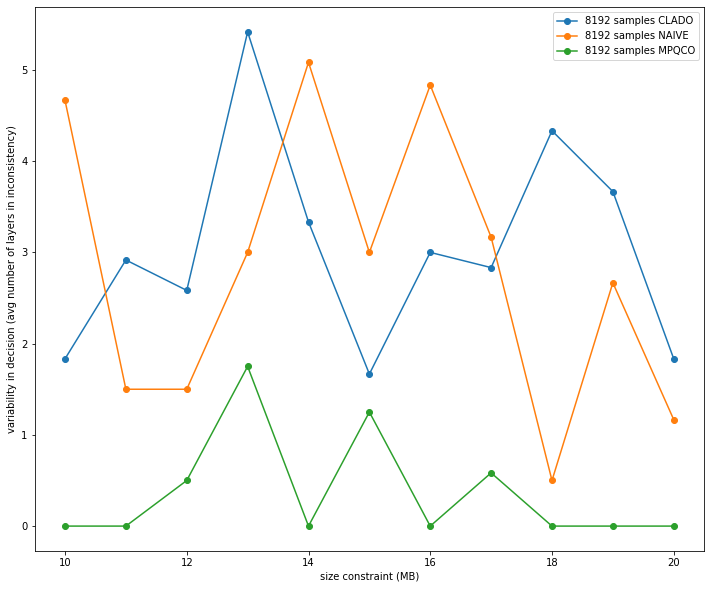

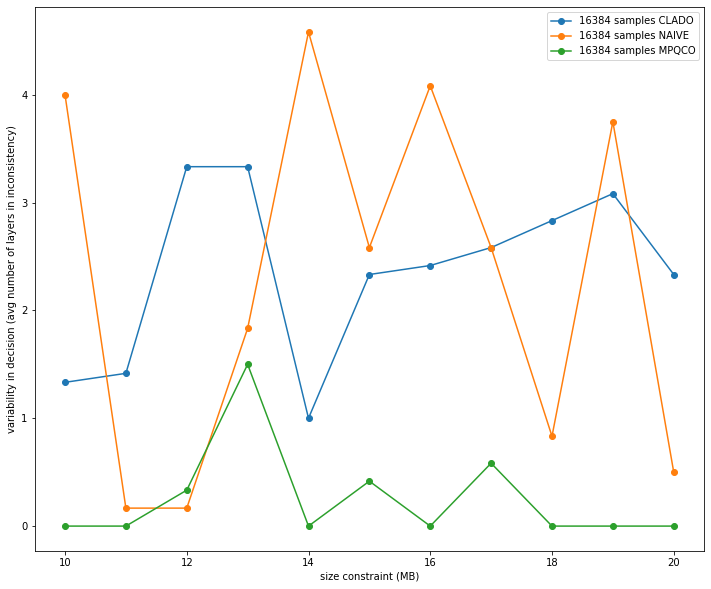

In [26]:
xs = np.linspace(10,20,11)
for i in range(diff_cladoss.shape[1]):
    plt.plot(xs,diff_cladoss[:,i,:].mean(axis=0),marker='o',label=f'{2**i *64} samples CLADO')
    plt.plot(xs,diff_naivess[:,i,:].mean(axis=0),marker='o',label=f'{2**i *64} samples NAIVE')
    plt.plot(xs,diff_mpqcoss[:,i,:].mean(axis=0),marker='o',label=f'{2**i *64} samples MPQCO')
    plt.legend()
    plt.ylabel('variability in decision (avg number of layers in inconsistency)')
    plt.xlabel('size constraint (MB)')
    plt.show()
